In [1]:
# 1. Instalar bibliotecas necess√°rias
!pip install geopandas rasterio rasterstats fiona shapely tqdm --quiet

     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 56.6/56.6 kB 1.4 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 22.2/22.2 MB 18.3 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 17.3/17.3 MB 21.6 MB/s eta 0:00:00


In [2]:
# 2. Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import glob
import shutil
import re
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.mask import mask
import geopandas as gpd
from tqdm import tqdm
import pandas as pd
from rasterstats import zonal_stats
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# 2. Definir caminhos (ADAPTE para seu Drive)
# pasta_indices AGORA √â A PASTA RAIZ QUE CONT√âM AS SUBPASTAS DOS √çNDICES
pasta_indices_base = '/content/drive/MyDrive/Dissertacao/indices/ouro_fino/openEO'
shapefile_talhoes_path = '/content/drive/MyDrive/Dissertacao/areas/fazenda_OuroFino2/fazenda_ourofino2.shp'
# Estas s√£o as PASTAS RAIZ para os outputs. As subpastas de √≠ndice ser√£o criadas DENTRO delas.
pasta_reprojetada_raiz = '/content/drive/MyDrive/Dissertacao/indices/indices_reprojetados/ouro_fino'
pasta_recortada_raiz = '/content/drive/MyDrive/Dissertacao/indices/indices_recortados/ouro_fino'


In [5]:
# 3. Carregar e Preparar Shapefile dos Talh√µes
try:
    gdf_talhoes = gpd.read_file(shapefile_talhoes_path)
    print(f"Shapefile de talh√µes carregado de: {shapefile_talhoes_path}")

    target_crs_str = 'EPSG:32723'
    if gdf_talhoes.crs is None:
        print(f"AVISO: Shapefile {shapefile_talhoes_path} n√£o tem CRS definido. Tentando atribuir EPSG:4326 e reprojetar.")
        try:
            gdf_talhoes = gdf_talhoes.set_crs('EPSG:4326', allow_override=True)
            gdf_talhoes = gdf_talhoes.to_crs(target_crs_str)
            print(f"Shapefile atribu√≠do com EPSG:4326 e reprojetado para {target_crs_str}.")
        except Exception as e_crs:
            print(f"ERRO ao tentar definir CRS e reprojetar shapefile: {e_crs}. Verifique o CRS original do shapefile.")
            raise # Para a execu√ß√£o se o shapefile n√£o puder ser preparado
    elif gdf_talhoes.crs.to_string().upper() != target_crs_str:
        print(f"Reprojetando shapefile de '{gdf_talhoes.crs.to_string()}' para {target_crs_str}...")
        gdf_talhoes = gdf_talhoes.to_crs(target_crs_str)
        print(f"Shapefile reprojetado para {target_crs_str}.")
    else:
        print(f"Shapefile de talh√µes j√° est√° na proje√ß√£o {target_crs_str}.")

    shapes_para_mascara = [feature["geometry"] for feature in gdf_talhoes.__geo_interface__["features"]]
    if not shapes_para_mascara:
        raise ValueError("Nenhuma geometria encontrada no shapefile de talh√µes para usar como m√°scara.")

except Exception as e:
    print(f"Erro cr√≠tico ao carregar ou processar o shapefile de talh√µes: {e}")
    # Considerar parar o script se o shapefile for essencial
    # raise

Shapefile de talh√µes carregado de: /content/drive/MyDrive/Dissertacao/areas/fazenda_OuroFino2/fazenda_ourofino2.shp
Shapefile de talh√µes j√° est√° na proje√ß√£o EPSG:32723.


In [6]:
# 4. Fun√ß√£o para reprojetar e recortar as imagens
# MODIFICADO: Os par√¢metros de pasta de sa√≠da agora s√£o as pastas RAIZ
def reprojetar_e_recortar_imagem(arquivo_tif_completo,
                                 pasta_saida_reprojetada_RAIZ,
                                 pasta_saida_recortada_RAIZ,
                                 geodataframe_talhoes,
                                 target_crs='EPSG:32723'): # Adicionado target_crs como par√¢metro

    nome_base_original_tif = os.path.basename(arquivo_tif_completo) # Ex: NDVI_2018-05.tif

    # MODIFICA√á√ÉO: Extrair o nome do √≠ndice do nome do arquivo
    # Assume que o nome do √≠ndice √© a primeira parte antes do primeiro underscore.
    # Ex: "NDVI_2018-05.tif" -> "NDVI"
    # Ex: "GNDVI_qualquercoisa.tif" -> "GNDVI"
    match_indice = re.match(r"([A-Za-z0-9]+)", nome_base_original_tif)
    if not match_indice:
        print(f"AVISO: N√£o foi poss√≠vel extrair o nome do √≠ndice do arquivo: {nome_base_original_tif}. Pulando.")
        return

    nome_do_indice = match_indice.group(1)
    # print(f"  √çndice detectado: {nome_do_indice} para arquivo {nome_base_original_tif}")

    # MODIFICA√á√ÉO: Criar/definir caminhos de sa√≠da espec√≠ficos para o √≠ndice
    pasta_saida_reprojetada_indice_especifica = os.path.join(pasta_saida_reprojetada_RAIZ, nome_do_indice)
    pasta_saida_recortada_indice_especifica = os.path.join(pasta_saida_recortada_RAIZ, nome_do_indice)

    os.makedirs(pasta_saida_reprojetada_indice_especifica, exist_ok=True)
    os.makedirs(pasta_saida_recortada_indice_especifica, exist_ok=True)

    # Caminho completo do arquivo de sa√≠da reprojetado
    caminho_saida_reprojetada_completo = os.path.join(pasta_saida_reprojetada_indice_especifica, nome_base_original_tif)

    # Reproje√ß√£o
    try:
        with rasterio.open(arquivo_tif_completo) as src:
            # Verifica se a reproje√ß√£o √© necess√°ria ou se o arquivo j√° existe e est√° atualizado
            reprojetar = True
            if src.crs and src.crs.to_string().upper() == target_crs.upper():
                # print(f'  Imagem {nome_base_original_tif} j√° est√° na proje√ß√£o {target_crs}. Verificando se precisa copiar...')
                if os.path.exists(caminho_saida_reprojetada_completo) and \
                   os.path.getmtime(arquivo_tif_completo) <= os.path.getmtime(caminho_saida_reprojetada_completo):
                    # print(f'  Arquivo reprojetado j√° existe e est√° atualizado: {caminho_saida_reprojetada_completo}')
                    reprojetar = False # N√£o precisa copiar nem reprojetar
                else: # Copiar pois n√£o existe ou est√° desatualizado
                    shutil.copy(arquivo_tif_completo, caminho_saida_reprojetada_completo)
                    # print(f'  Copiado (j√° no CRS correto): {caminho_saida_reprojetada_completo}')
                    reprojetar = False # J√° copiou, n√£o precisa da l√≥gica de reproje√ß√£o abaixo

            if reprojetar:
                # print(f'  Reprojetando {nome_base_original_tif} de {src.crs} para {target_crs}...')
                transform, width, height = calculate_default_transform(
                    src.crs, target_crs, src.width, src.height, *src.bounds)
                kwargs = src.meta.copy()
                kwargs.update({
                    'crs': target_crs,
                    'transform': transform,
                    'width': width,
                    'height': height,
                    'compress': 'LZW'
                })

                with rasterio.open(caminho_saida_reprojetada_completo, 'w', **kwargs) as dst:
                    for i in range(1, src.count + 1):
                        reproject(
                            source=rasterio.band(src, i),
                            destination=rasterio.band(dst, i),
                            src_transform=src.transform,
                            src_crs=src.crs,
                            dst_transform=transform,
                            dst_crs=target_crs, # Passar a string do CRS aqui
                            resampling=Resampling.nearest)
                # print(f'  Reproje√ß√£o conclu√≠da: {caminho_saida_reprojetada_completo}')
    except Exception as e_reproj:
        print(f"ERRO durante reproje√ß√£o de {arquivo_tif_completo}: {e_reproj}")
        return # Pula para o pr√≥ximo arquivo se a reproje√ß√£o falhar

    # Recorte com base no shapefile (usando o arquivo reprojetado)
    # print(f'  Recortando {nome_base_original_tif}...')
    try:
        # shapes_para_mascara √© definido globalmente
        with rasterio.open(caminho_saida_reprojetada_completo) as src_reproj: # Abrir o arquivo rec√©m-reprojetado/copiado
            # Garantir que nodata seja um valor float se o raster for float, ou int se for int.
            # Usar o nodata do raster de origem se existir, sen√£o um default.
            nodata_val_src = src_reproj.nodata
            if nodata_val_src is None: # Se n√£o h√° nodata definido no raster
                if 'float' in str(src_reproj.meta['dtype']).lower():
                    nodata_val_src = -9999.0 # Um float para NoData
                else:
                    nodata_val_src = -9999 # Um int para NoData

            out_image, out_transform = mask(src_reproj, shapes_para_mascara, crop=True, filled=True, nodata=nodata_val_src)

            caminho_saida_recortada_completo = os.path.join(pasta_saida_recortada_indice_especifica, nome_base_original_tif)

            kwargs_recorte = src_reproj.meta.copy()
            kwargs_recorte.update({
                'height': out_image.shape[1],
                'width': out_image.shape[2],
                'transform': out_transform,
                'compress': 'LZW',
                'nodata': nodata_val_src # Propagar o valor NoData
            })
            with rasterio.open(caminho_saida_recortada_completo, 'w', **kwargs_recorte) as dst:
                dst.write(out_image)

            # print(f'  Recorte conclu√≠do: {caminho_saida_recortada_completo}')
    except Exception as e_mask:
        print(f"ERRO durante recorte de {caminho_saida_reprojetada_completo}: {e_mask}")

# 5. Obter lista de todos os arquivos .tif na pasta_indices_base e suas subpastas
# Esta forma garante que estamos pegando de DENTRO das pastas NDVI, NDRE, etc.
arquivos_tif_todos = []
# Listar as subpastas de √≠ndices (NDVI, NDRE, etc.)
# MODIFICA√á√ÉO: Garante que pasta_indices_base exista
if not os.path.isdir(pasta_indices_base):
    print(f"ERRO: A pasta base de √≠ndices '{pasta_indices_base}' n√£o foi encontrada!")
else:
    for nome_subpasta_indice in os.listdir(pasta_indices_base):
        caminho_subpasta_indice_atual = os.path.join(pasta_indices_base, nome_subpasta_indice)
        if os.path.isdir(caminho_subpasta_indice_atual):
            # Glob para pegar .tif dentro de cada pasta de √≠ndice
            arquivos_neste_indice = glob.glob(os.path.join(caminho_subpasta_indice_atual, '*.tif'))
            # Alternativa se os nomes n√£o tiverem o √≠ndice neles e voc√™ quiser usar o nome da pasta:
            # arquivos_neste_indice = glob.glob(os.path.join(caminho_subpasta_indice_atual, f"{nome_subpasta_indice}_*.tif"))
            arquivos_tif_todos.extend(arquivos_neste_indice)

arquivos_tif_todos = sorted(arquivos_tif_todos)

if not arquivos_tif_todos:
    print(f"Nenhum arquivo .tif encontrado em '{pasta_indices_base}' e suas subpastas. Verifique o caminho.")
else:
    print(f"Encontrados {len(arquivos_tif_todos)} arquivos .tif para processar.")

    # 6. Reprojetar e recortar todos os arquivos encontrados
    if 'gdf_talhoes' in locals() and 'shapes_para_mascara' in locals(): # Checa se o shapefile foi carregado
        for arquivo_tif_original in tqdm(arquivos_tif_todos, desc="Reprojetando e recortando imagens"):
            # print(f"\nProcessando: {arquivo_tif_original}") # Descomente para mais verbosidade
            reprojetar_e_recortar_imagem( # Nome da fun√ß√£o original mantido
                arquivo_tif_original,
                pasta_reprojetada_raiz,   # Passa a pasta RAIZ
                pasta_recortada_raiz,     # Passa a pasta RAIZ
                gdf_talhoes               # Passa o geodataframe carregado
            )
    else:
        print("ERRO: Shapefile dos talh√µes (gdf_talhoes) n√£o foi carregado corretamente. Processamento de imagens abortado.")


print("\n--- Processamento de reproje√ß√£o e recorte conclu√≠do ---")

Encontrados 293 arquivos .tif para processar.


Reprojetando e recortando imagens: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 293/293 [02:42<00:00,  1.80it/s]


--- Processamento de reproje√ß√£o e recorte conclu√≠do ---


In [ ]:
# Estat√≠sticas zonais
arquivos_recortados = sorted(glob.glob(os.path.join(pasta_recortada, '**', '*.tif'), recursive=True))
resultados = []

for arquivo in tqdm(arquivos_recortados, desc="Calculando estat√≠sticas"):
    caminho_raster = arquivo
    nome_base = os.path.basename(arquivo).replace('.tif', '')

    print(f"Verificando nome do arquivo: {nome_base}")
    match = re.match(r"([A-Za-z0-9]+).*?(\d{4}-\d{2})", nome_base)
    if not match:
        print(f"Nome inv√°lido: {nome_base}")
        continue

    indice = match.group(1)
    data = match.group(2)

    try:
        stats = zonal_stats(
            gdf_talhoes,
            caminho_raster,
            stats=["mean", "min", "max"],
            geojson_out=True,
            nodata=-9999
        )
    except Exception as e:
        print(f"Erro ao processar {arquivo}: {e}")
        continue

    for stat in stats:
        prop = stat['properties']
        resultados.append({
            'indice': indice,
            'data': data,
            'id_talhao': prop.get(col_id_talhao),
            'mean': prop.get('mean'),
            'min': prop.get('min'),
            'max': prop.get('max')
        })

# Criar DataFrame com verifica√ß√£o
df = pd.DataFrame(resultados)

if not df.empty:
    df['data'] = pd.to_datetime(df['data'], format='%Y-%m')
else:
    print("‚ö†Ô∏è Nenhum dado processado com sucesso. Verifique os nomes dos arquivos e dados.")


Calculando estat√≠sticas:   0%|          | 0/612 [00:00<?, ?it/s]

Verificando nome do arquivo: GNDVI_2018-05


Calculando estat√≠sticas:   0%|          | 1/612 [00:00<04:02,  2.52it/s]

Verificando nome do arquivo: GNDVI_2018-06


Calculando estat√≠sticas:   0%|          | 2/612 [00:00<04:40,  2.17it/s]

Verificando nome do arquivo: GNDVI_2018-07


Calculando estat√≠sticas:   0%|          | 3/612 [00:01<04:49,  2.10it/s]

Verificando nome do arquivo: GNDVI_2018-08


Calculando estat√≠sticas:   1%|          | 4/612 [00:01<04:54,  2.06it/s]

Verificando nome do arquivo: GNDVI_2018-09


Calculando estat√≠sticas:   1%|          | 5/612 [00:02<05:00,  2.02it/s]

Verificando nome do arquivo: GNDVI_2018-12


Calculando estat√≠sticas:   1%|          | 6/612 [00:02<05:03,  1.99it/s]

Verificando nome do arquivo: GNDVI_2019-01


Calculando estat√≠sticas:   1%|          | 7/612 [00:04<10:02,  1.00it/s]

Verificando nome do arquivo: GNDVI_2019-02


Calculando estat√≠sticas:   1%|‚ñè         | 8/612 [00:05<08:04,  1.25it/s]

Verificando nome do arquivo: GNDVI_2019-03


Calculando estat√≠sticas:   1%|‚ñè         | 9/612 [00:05<06:49,  1.47it/s]

Verificando nome do arquivo: GNDVI_2019-04


Calculando estat√≠sticas:   2%|‚ñè         | 10/612 [00:06<05:53,  1.70it/s]

Verificando nome do arquivo: GNDVI_2019-05


Calculando estat√≠sticas:   2%|‚ñè         | 11/612 [00:06<05:11,  1.93it/s]

Verificando nome do arquivo: GNDVI_2019-06


Calculando estat√≠sticas:   2%|‚ñè         | 12/612 [00:06<04:46,  2.09it/s]

Verificando nome do arquivo: GNDVI_2019-07


Calculando estat√≠sticas:   2%|‚ñè         | 13/612 [00:07<04:34,  2.18it/s]

Verificando nome do arquivo: GNDVI_2019-08


Calculando estat√≠sticas:   2%|‚ñè         | 14/612 [00:07<04:18,  2.31it/s]

Verificando nome do arquivo: GNDVI_2019-09


Calculando estat√≠sticas:   2%|‚ñè         | 15/612 [00:08<04:09,  2.39it/s]

Verificando nome do arquivo: GNDVI_2019-10


Calculando estat√≠sticas:   3%|‚ñé         | 16/612 [00:08<04:00,  2.47it/s]

Verificando nome do arquivo: GNDVI_2019-11


Calculando estat√≠sticas:   3%|‚ñé         | 17/612 [00:08<03:58,  2.50it/s]

Verificando nome do arquivo: GNDVI_2020-04


Calculando estat√≠sticas:   3%|‚ñé         | 18/612 [00:09<03:52,  2.55it/s]

Verificando nome do arquivo: GNDVI_2020-05


Calculando estat√≠sticas:   3%|‚ñé         | 19/612 [00:09<03:50,  2.58it/s]

Verificando nome do arquivo: GNDVI_2020-06


Calculando estat√≠sticas:   3%|‚ñé         | 20/612 [00:09<03:50,  2.57it/s]

Verificando nome do arquivo: GNDVI_2020-07


Calculando estat√≠sticas:   3%|‚ñé         | 21/612 [00:10<03:47,  2.60it/s]

Verificando nome do arquivo: GNDVI_2020-08


Calculando estat√≠sticas:   4%|‚ñé         | 22/612 [00:10<03:45,  2.61it/s]

Verificando nome do arquivo: GNDVI_2020-09


Calculando estat√≠sticas:   4%|‚ñç         | 23/612 [00:11<03:50,  2.56it/s]

Verificando nome do arquivo: GNDVI_2020-12


Calculando estat√≠sticas:   4%|‚ñç         | 24/612 [00:11<03:50,  2.56it/s]

Verificando nome do arquivo: GNDVI_2021-01


Calculando estat√≠sticas:   4%|‚ñç         | 25/612 [00:11<03:47,  2.57it/s]

Verificando nome do arquivo: GNDVI_2021-03


Calculando estat√≠sticas:   4%|‚ñç         | 26/612 [00:12<03:49,  2.55it/s]

Verificando nome do arquivo: GNDVI_2021-04


Calculando estat√≠sticas:   4%|‚ñç         | 27/612 [00:12<03:44,  2.61it/s]

Verificando nome do arquivo: GNDVI_2021-05


Calculando estat√≠sticas:   5%|‚ñç         | 28/612 [00:13<03:42,  2.63it/s]

Verificando nome do arquivo: GNDVI_2021-06


Calculando estat√≠sticas:   5%|‚ñç         | 29/612 [00:13<03:43,  2.60it/s]

Verificando nome do arquivo: GNDVI_2021-07


Calculando estat√≠sticas:   5%|‚ñç         | 30/612 [00:13<03:40,  2.64it/s]

Verificando nome do arquivo: GNDVI_2021-08


Calculando estat√≠sticas:   5%|‚ñå         | 31/612 [00:14<04:09,  2.33it/s]

Verificando nome do arquivo: GNDVI_2021-09


Calculando estat√≠sticas:   5%|‚ñå         | 32/612 [00:14<04:18,  2.25it/s]

Verificando nome do arquivo: GNDVI_2021-10


Calculando estat√≠sticas:   5%|‚ñå         | 33/612 [00:15<04:32,  2.13it/s]

Verificando nome do arquivo: GNDVI_2021-11


Calculando estat√≠sticas:   6%|‚ñå         | 34/612 [00:15<04:40,  2.06it/s]

Verificando nome do arquivo: GNDVI_2022-01


Calculando estat√≠sticas:   6%|‚ñå         | 35/612 [00:16<04:47,  2.01it/s]

Verificando nome do arquivo: GNDVI_2022-03


Calculando estat√≠sticas:   6%|‚ñå         | 36/612 [00:16<04:52,  1.97it/s]

Verificando nome do arquivo: GNDVI_2022-04


Calculando estat√≠sticas:   6%|‚ñå         | 37/612 [00:17<04:42,  2.03it/s]

Verificando nome do arquivo: GNDVI_2022-05


Calculando estat√≠sticas:   6%|‚ñå         | 38/612 [00:17<04:24,  2.17it/s]

Verificando nome do arquivo: GNDVI_2022-06


Calculando estat√≠sticas:   6%|‚ñã         | 39/612 [00:18<04:09,  2.29it/s]

Verificando nome do arquivo: GNDVI_2022-07


Calculando estat√≠sticas:   7%|‚ñã         | 40/612 [00:18<04:00,  2.38it/s]

Verificando nome do arquivo: GNDVI_2022-08


Calculando estat√≠sticas:   7%|‚ñã         | 41/612 [00:18<03:58,  2.40it/s]

Verificando nome do arquivo: GNDVI_2022-09


Calculando estat√≠sticas:   7%|‚ñã         | 42/612 [00:19<03:49,  2.48it/s]

Verificando nome do arquivo: GNDVI_2022-11


Calculando estat√≠sticas:   7%|‚ñã         | 43/612 [00:19<03:48,  2.49it/s]

Verificando nome do arquivo: GNDVI_2022-12


Calculando estat√≠sticas:   7%|‚ñã         | 44/612 [00:20<03:45,  2.52it/s]

Verificando nome do arquivo: GNDVI_2023-02


Calculando estat√≠sticas:   7%|‚ñã         | 45/612 [00:20<03:41,  2.57it/s]

Verificando nome do arquivo: GNDVI_2023-04


Calculando estat√≠sticas:   8%|‚ñä         | 46/612 [00:20<03:38,  2.59it/s]

Verificando nome do arquivo: GNDVI_2023-05


Calculando estat√≠sticas:   8%|‚ñä         | 47/612 [00:21<03:35,  2.62it/s]

Verificando nome do arquivo: GNDVI_2023-06


Calculando estat√≠sticas:   8%|‚ñä         | 48/612 [00:21<03:39,  2.57it/s]

Verificando nome do arquivo: GNDVI_2023-07


Calculando estat√≠sticas:   8%|‚ñä         | 49/612 [00:21<03:35,  2.61it/s]

Verificando nome do arquivo: GNDVI_2023-08


Calculando estat√≠sticas:   8%|‚ñä         | 50/612 [00:22<03:36,  2.60it/s]

Verificando nome do arquivo: GNDVI_2023-09


Calculando estat√≠sticas:   8%|‚ñä         | 51/612 [00:22<03:35,  2.61it/s]

Verificando nome do arquivo: GNDVI_2023-11


Calculando estat√≠sticas:   8%|‚ñä         | 52/612 [00:23<03:33,  2.63it/s]

Verificando nome do arquivo: GNDVI_2023-12


Calculando estat√≠sticas:   9%|‚ñä         | 53/612 [00:23<03:36,  2.58it/s]

Verificando nome do arquivo: GNDVI_2024-01


Calculando estat√≠sticas:   9%|‚ñâ         | 54/612 [00:23<03:36,  2.58it/s]

Verificando nome do arquivo: GNDVI_2024-02


Calculando estat√≠sticas:   9%|‚ñâ         | 55/612 [00:24<03:34,  2.59it/s]

Verificando nome do arquivo: GNDVI_2024-04


Calculando estat√≠sticas:   9%|‚ñâ         | 56/612 [00:24<03:33,  2.61it/s]

Verificando nome do arquivo: GNDVI_2024-05


Calculando estat√≠sticas:   9%|‚ñâ         | 57/612 [00:25<03:38,  2.54it/s]

Verificando nome do arquivo: GNDVI_2024-06


Calculando estat√≠sticas:   9%|‚ñâ         | 58/612 [00:25<03:35,  2.57it/s]

Verificando nome do arquivo: GNDVI_2024-07


Calculando estat√≠sticas:  10%|‚ñâ         | 59/612 [00:25<03:32,  2.60it/s]

Verificando nome do arquivo: GNDVI_2024-08


Calculando estat√≠sticas:  10%|‚ñâ         | 60/612 [00:26<03:30,  2.62it/s]

Verificando nome do arquivo: GNDVI_2024-09


Calculando estat√≠sticas:  10%|‚ñâ         | 61/612 [00:26<03:32,  2.59it/s]

Verificando nome do arquivo: GNDVI_2024-10


Calculando estat√≠sticas:  10%|‚ñà         | 62/612 [00:26<03:31,  2.61it/s]

Verificando nome do arquivo: GNDVI_2024-11


Calculando estat√≠sticas:  10%|‚ñà         | 63/612 [00:27<03:55,  2.33it/s]

Verificando nome do arquivo: GNDVI_2025-01


Calculando estat√≠sticas:  10%|‚ñà         | 64/612 [00:28<04:11,  2.18it/s]

Verificando nome do arquivo: GNDVI_2025-02


Calculando estat√≠sticas:  11%|‚ñà         | 65/612 [00:28<04:21,  2.09it/s]

Verificando nome do arquivo: GNDVI_2025-03


Calculando estat√≠sticas:  11%|‚ñà         | 66/612 [00:29<04:29,  2.03it/s]

Verificando nome do arquivo: GNDVI_2025-04


Calculando estat√≠sticas:  11%|‚ñà         | 67/612 [00:29<04:30,  2.01it/s]

Verificando nome do arquivo: GNDVI_2025-05


Calculando estat√≠sticas:  11%|‚ñà         | 68/612 [00:30<04:36,  1.97it/s]

Verificando nome do arquivo: GOSAVI_2018-05


Calculando estat√≠sticas:  11%|‚ñà‚ñè        | 69/612 [00:30<04:25,  2.05it/s]

Verificando nome do arquivo: GOSAVI_2018-06


Calculando estat√≠sticas:  11%|‚ñà‚ñè        | 70/612 [00:30<04:05,  2.21it/s]

Verificando nome do arquivo: GOSAVI_2018-07


Calculando estat√≠sticas:  12%|‚ñà‚ñè        | 71/612 [00:31<03:49,  2.36it/s]

Verificando nome do arquivo: GOSAVI_2018-08


Calculando estat√≠sticas:  12%|‚ñà‚ñè        | 72/612 [00:31<03:37,  2.48it/s]

Verificando nome do arquivo: GOSAVI_2018-09


Calculando estat√≠sticas:  12%|‚ñà‚ñè        | 73/612 [00:32<03:36,  2.49it/s]

Verificando nome do arquivo: GOSAVI_2018-12


Calculando estat√≠sticas:  12%|‚ñà‚ñè        | 74/612 [00:32<03:31,  2.54it/s]

Verificando nome do arquivo: GOSAVI_2019-01


Calculando estat√≠sticas:  12%|‚ñà‚ñè        | 75/612 [00:32<03:27,  2.59it/s]

Verificando nome do arquivo: GOSAVI_2019-02


Calculando estat√≠sticas:  12%|‚ñà‚ñè        | 76/612 [00:33<03:29,  2.56it/s]

Verificando nome do arquivo: GOSAVI_2019-03


Calculando estat√≠sticas:  13%|‚ñà‚ñé        | 77/612 [00:33<03:25,  2.60it/s]

Verificando nome do arquivo: GOSAVI_2019-04


Calculando estat√≠sticas:  13%|‚ñà‚ñé        | 78/612 [00:33<03:23,  2.62it/s]

Verificando nome do arquivo: GOSAVI_2019-05


Calculando estat√≠sticas:  13%|‚ñà‚ñé        | 79/612 [00:34<03:25,  2.60it/s]

Verificando nome do arquivo: GOSAVI_2019-06


Calculando estat√≠sticas:  13%|‚ñà‚ñé        | 80/612 [00:34<03:22,  2.63it/s]

Verificando nome do arquivo: GOSAVI_2019-07


Calculando estat√≠sticas:  13%|‚ñà‚ñé        | 81/612 [00:35<03:24,  2.59it/s]

Verificando nome do arquivo: GOSAVI_2019-08


Calculando estat√≠sticas:  13%|‚ñà‚ñé        | 82/612 [00:35<03:22,  2.61it/s]

Verificando nome do arquivo: GOSAVI_2019-09


Calculando estat√≠sticas:  14%|‚ñà‚ñé        | 83/612 [00:35<03:20,  2.64it/s]

Verificando nome do arquivo: GOSAVI_2019-10


Calculando estat√≠sticas:  14%|‚ñà‚ñé        | 84/612 [00:36<03:21,  2.63it/s]

Verificando nome do arquivo: GOSAVI_2019-11


Calculando estat√≠sticas:  14%|‚ñà‚ñç        | 85/612 [00:36<03:20,  2.63it/s]

Verificando nome do arquivo: GOSAVI_2020-04


Calculando estat√≠sticas:  14%|‚ñà‚ñç        | 86/612 [00:37<03:23,  2.58it/s]

Verificando nome do arquivo: GOSAVI_2020-05


Calculando estat√≠sticas:  14%|‚ñà‚ñç        | 87/612 [00:37<03:23,  2.58it/s]

Verificando nome do arquivo: GOSAVI_2020-06


Calculando estat√≠sticas:  14%|‚ñà‚ñç        | 88/612 [00:37<03:21,  2.60it/s]

Verificando nome do arquivo: GOSAVI_2020-07


Calculando estat√≠sticas:  15%|‚ñà‚ñç        | 89/612 [00:38<03:19,  2.62it/s]

Verificando nome do arquivo: GOSAVI_2020-08


Calculando estat√≠sticas:  15%|‚ñà‚ñç        | 90/612 [00:38<03:18,  2.64it/s]

Verificando nome do arquivo: GOSAVI_2020-09


Calculando estat√≠sticas:  15%|‚ñà‚ñç        | 91/612 [00:38<03:18,  2.62it/s]

Verificando nome do arquivo: GOSAVI_2020-12


Calculando estat√≠sticas:  15%|‚ñà‚ñå        | 92/612 [00:39<03:23,  2.55it/s]

Verificando nome do arquivo: GOSAVI_2021-01


Calculando estat√≠sticas:  15%|‚ñà‚ñå        | 93/612 [00:39<03:22,  2.56it/s]

Verificando nome do arquivo: GOSAVI_2021-03


Calculando estat√≠sticas:  15%|‚ñà‚ñå        | 94/612 [00:40<03:23,  2.55it/s]

Verificando nome do arquivo: GOSAVI_2021-04


Calculando estat√≠sticas:  16%|‚ñà‚ñå        | 95/612 [00:40<03:32,  2.43it/s]

Verificando nome do arquivo: GOSAVI_2021-05


Calculando estat√≠sticas:  16%|‚ñà‚ñå        | 96/612 [00:41<03:48,  2.25it/s]

Verificando nome do arquivo: GOSAVI_2021-06


Calculando estat√≠sticas:  16%|‚ñà‚ñå        | 97/612 [00:41<04:17,  2.00it/s]

Verificando nome do arquivo: GOSAVI_2021-07


Calculando estat√≠sticas:  16%|‚ñà‚ñå        | 98/612 [00:42<04:21,  1.97it/s]

Verificando nome do arquivo: GOSAVI_2021-08


Calculando estat√≠sticas:  16%|‚ñà‚ñå        | 99/612 [00:42<04:18,  1.99it/s]

Verificando nome do arquivo: GOSAVI_2021-09


Calculando estat√≠sticas:  16%|‚ñà‚ñã        | 100/612 [00:43<04:26,  1.92it/s]

Verificando nome do arquivo: GOSAVI_2021-10


Calculando estat√≠sticas:  17%|‚ñà‚ñã        | 101/612 [00:43<04:20,  1.96it/s]

Verificando nome do arquivo: GOSAVI_2021-11


Calculando estat√≠sticas:  17%|‚ñà‚ñã        | 102/612 [00:44<03:58,  2.13it/s]

Verificando nome do arquivo: GOSAVI_2022-01


Calculando estat√≠sticas:  17%|‚ñà‚ñã        | 103/612 [00:44<03:47,  2.24it/s]

Verificando nome do arquivo: GOSAVI_2022-03


Calculando estat√≠sticas:  17%|‚ñà‚ñã        | 104/612 [00:44<03:35,  2.36it/s]

Verificando nome do arquivo: GOSAVI_2022-04


Calculando estat√≠sticas:  17%|‚ñà‚ñã        | 105/612 [00:45<03:32,  2.38it/s]

Verificando nome do arquivo: GOSAVI_2022-05


Calculando estat√≠sticas:  17%|‚ñà‚ñã        | 106/612 [00:45<03:30,  2.41it/s]

Verificando nome do arquivo: GOSAVI_2022-06


Calculando estat√≠sticas:  17%|‚ñà‚ñã        | 107/612 [00:46<03:25,  2.46it/s]

Verificando nome do arquivo: GOSAVI_2022-07


Calculando estat√≠sticas:  18%|‚ñà‚ñä        | 108/612 [00:46<03:21,  2.50it/s]

Verificando nome do arquivo: GOSAVI_2022-08


Calculando estat√≠sticas:  18%|‚ñà‚ñä        | 109/612 [00:46<03:21,  2.49it/s]

Verificando nome do arquivo: GOSAVI_2022-09


Calculando estat√≠sticas:  18%|‚ñà‚ñä        | 110/612 [00:47<03:29,  2.40it/s]

Verificando nome do arquivo: GOSAVI_2022-11


Calculando estat√≠sticas:  18%|‚ñà‚ñä        | 111/612 [00:47<03:23,  2.46it/s]

Verificando nome do arquivo: GOSAVI_2022-12


Calculando estat√≠sticas:  18%|‚ñà‚ñä        | 112/612 [00:48<03:19,  2.50it/s]

Verificando nome do arquivo: GOSAVI_2023-02


Calculando estat√≠sticas:  18%|‚ñà‚ñä        | 113/612 [00:48<03:14,  2.57it/s]

Verificando nome do arquivo: GOSAVI_2023-04


Calculando estat√≠sticas:  19%|‚ñà‚ñä        | 114/612 [00:48<03:14,  2.56it/s]

Verificando nome do arquivo: GOSAVI_2023-05


Calculando estat√≠sticas:  19%|‚ñà‚ñâ        | 115/612 [00:49<03:14,  2.55it/s]

Verificando nome do arquivo: GOSAVI_2023-06


Calculando estat√≠sticas:  19%|‚ñà‚ñâ        | 116/612 [00:49<03:13,  2.57it/s]

Verificando nome do arquivo: GOSAVI_2023-07


Calculando estat√≠sticas:  19%|‚ñà‚ñâ        | 117/612 [00:50<03:10,  2.60it/s]

Verificando nome do arquivo: GOSAVI_2023-08


Calculando estat√≠sticas:  19%|‚ñà‚ñâ        | 118/612 [00:50<03:08,  2.62it/s]

Verificando nome do arquivo: GOSAVI_2023-09


Calculando estat√≠sticas:  19%|‚ñà‚ñâ        | 119/612 [00:50<03:09,  2.61it/s]

Verificando nome do arquivo: GOSAVI_2023-11


Calculando estat√≠sticas:  20%|‚ñà‚ñâ        | 120/612 [00:51<03:09,  2.59it/s]

Verificando nome do arquivo: GOSAVI_2023-12


Calculando estat√≠sticas:  20%|‚ñà‚ñâ        | 121/612 [00:51<03:07,  2.62it/s]

Verificando nome do arquivo: GOSAVI_2024-01


Calculando estat√≠sticas:  20%|‚ñà‚ñâ        | 122/612 [00:51<03:09,  2.59it/s]

Verificando nome do arquivo: GOSAVI_2024-02


Calculando estat√≠sticas:  20%|‚ñà‚ñà        | 123/612 [00:52<03:09,  2.58it/s]

Verificando nome do arquivo: GOSAVI_2024-04


Calculando estat√≠sticas:  20%|‚ñà‚ñà        | 124/612 [00:52<03:09,  2.57it/s]

Verificando nome do arquivo: GOSAVI_2024-05


Calculando estat√≠sticas:  20%|‚ñà‚ñà        | 125/612 [00:53<03:08,  2.59it/s]

Verificando nome do arquivo: GOSAVI_2024-06


Calculando estat√≠sticas:  21%|‚ñà‚ñà        | 126/612 [00:53<03:06,  2.61it/s]

Verificando nome do arquivo: GOSAVI_2024-07


Calculando estat√≠sticas:  21%|‚ñà‚ñà        | 127/612 [00:54<03:23,  2.39it/s]

Verificando nome do arquivo: GOSAVI_2024-08


Calculando estat√≠sticas:  21%|‚ñà‚ñà        | 128/612 [00:54<03:37,  2.23it/s]

Verificando nome do arquivo: GOSAVI_2024-09


Calculando estat√≠sticas:  21%|‚ñà‚ñà        | 129/612 [00:55<03:53,  2.07it/s]

Verificando nome do arquivo: GOSAVI_2024-10


Calculando estat√≠sticas:  21%|‚ñà‚ñà        | 130/612 [00:55<03:54,  2.05it/s]

Verificando nome do arquivo: GOSAVI_2024-11


Calculando estat√≠sticas:  21%|‚ñà‚ñà‚ñè       | 131/612 [00:56<03:59,  2.01it/s]

Verificando nome do arquivo: GOSAVI_2025-01


Calculando estat√≠sticas:  22%|‚ñà‚ñà‚ñè       | 132/612 [00:56<04:06,  1.95it/s]

Verificando nome do arquivo: GOSAVI_2025-02


Calculando estat√≠sticas:  22%|‚ñà‚ñà‚ñè       | 133/612 [00:57<04:02,  1.97it/s]

Verificando nome do arquivo: GOSAVI_2025-03


Calculando estat√≠sticas:  22%|‚ñà‚ñà‚ñè       | 134/612 [00:57<03:45,  2.12it/s]

Verificando nome do arquivo: GOSAVI_2025-04


Calculando estat√≠sticas:  22%|‚ñà‚ñà‚ñè       | 135/612 [00:57<03:31,  2.26it/s]

Verificando nome do arquivo: GOSAVI_2025-05


Calculando estat√≠sticas:  22%|‚ñà‚ñà‚ñè       | 136/612 [00:58<03:21,  2.36it/s]

Verificando nome do arquivo: LNC_2018-05


Calculando estat√≠sticas:  22%|‚ñà‚ñà‚ñè       | 137/612 [00:58<03:14,  2.44it/s]

Verificando nome do arquivo: LNC_2018-06


Calculando estat√≠sticas:  23%|‚ñà‚ñà‚ñé       | 138/612 [00:59<03:09,  2.50it/s]

Verificando nome do arquivo: LNC_2018-07


Calculando estat√≠sticas:  23%|‚ñà‚ñà‚ñé       | 139/612 [00:59<03:10,  2.49it/s]

Verificando nome do arquivo: LNC_2018-08


Calculando estat√≠sticas:  23%|‚ñà‚ñà‚ñé       | 140/612 [00:59<03:07,  2.51it/s]

Verificando nome do arquivo: LNC_2018-09


Calculando estat√≠sticas:  23%|‚ñà‚ñà‚ñé       | 141/612 [01:00<03:09,  2.49it/s]

Verificando nome do arquivo: LNC_2018-12


Calculando estat√≠sticas:  23%|‚ñà‚ñà‚ñé       | 142/612 [01:00<03:06,  2.52it/s]

Verificando nome do arquivo: LNC_2019-01


Calculando estat√≠sticas:  23%|‚ñà‚ñà‚ñé       | 143/612 [01:01<03:04,  2.54it/s]

Verificando nome do arquivo: LNC_2019-02


Calculando estat√≠sticas:  24%|‚ñà‚ñà‚ñé       | 144/612 [01:01<03:04,  2.54it/s]

Verificando nome do arquivo: LNC_2019-03


Calculando estat√≠sticas:  24%|‚ñà‚ñà‚ñé       | 145/612 [01:01<03:00,  2.58it/s]

Verificando nome do arquivo: LNC_2019-04


Calculando estat√≠sticas:  24%|‚ñà‚ñà‚ñç       | 146/612 [01:02<03:04,  2.53it/s]

Verificando nome do arquivo: LNC_2019-05


Calculando estat√≠sticas:  24%|‚ñà‚ñà‚ñç       | 147/612 [01:02<03:03,  2.54it/s]

Verificando nome do arquivo: LNC_2019-06


Calculando estat√≠sticas:  24%|‚ñà‚ñà‚ñç       | 148/612 [01:02<03:00,  2.57it/s]

Verificando nome do arquivo: LNC_2019-07


Calculando estat√≠sticas:  24%|‚ñà‚ñà‚ñç       | 149/612 [01:03<03:02,  2.53it/s]

Verificando nome do arquivo: LNC_2019-08


Calculando estat√≠sticas:  25%|‚ñà‚ñà‚ñç       | 150/612 [01:03<02:59,  2.58it/s]

Verificando nome do arquivo: LNC_2019-09


Calculando estat√≠sticas:  25%|‚ñà‚ñà‚ñç       | 151/612 [01:04<02:57,  2.60it/s]

Verificando nome do arquivo: LNC_2019-10


Calculando estat√≠sticas:  25%|‚ñà‚ñà‚ñç       | 152/612 [01:04<02:58,  2.58it/s]

Verificando nome do arquivo: LNC_2019-11


Calculando estat√≠sticas:  25%|‚ñà‚ñà‚ñå       | 153/612 [01:04<02:57,  2.58it/s]

Verificando nome do arquivo: LNC_2020-04


Calculando estat√≠sticas:  25%|‚ñà‚ñà‚ñå       | 154/612 [01:05<02:57,  2.58it/s]

Verificando nome do arquivo: LNC_2020-05


Calculando estat√≠sticas:  25%|‚ñà‚ñà‚ñå       | 155/612 [01:05<02:56,  2.59it/s]

Verificando nome do arquivo: LNC_2020-06


Calculando estat√≠sticas:  25%|‚ñà‚ñà‚ñå       | 156/612 [01:06<02:57,  2.57it/s]

Verificando nome do arquivo: LNC_2020-07


Calculando estat√≠sticas:  26%|‚ñà‚ñà‚ñå       | 157/612 [01:06<02:56,  2.58it/s]

Verificando nome do arquivo: LNC_2020-08


Calculando estat√≠sticas:  26%|‚ñà‚ñà‚ñå       | 158/612 [01:06<02:53,  2.61it/s]

Verificando nome do arquivo: LNC_2020-09


Calculando estat√≠sticas:  26%|‚ñà‚ñà‚ñå       | 159/612 [01:07<03:14,  2.33it/s]

Verificando nome do arquivo: LNC_2020-12


Calculando estat√≠sticas:  26%|‚ñà‚ñà‚ñå       | 160/612 [01:07<03:27,  2.18it/s]

Verificando nome do arquivo: LNC_2021-01


Calculando estat√≠sticas:  26%|‚ñà‚ñà‚ñã       | 161/612 [01:08<03:38,  2.07it/s]

Verificando nome do arquivo: LNC_2021-03


Calculando estat√≠sticas:  26%|‚ñà‚ñà‚ñã       | 162/612 [01:08<03:44,  2.01it/s]

Verificando nome do arquivo: LNC_2021-04


Calculando estat√≠sticas:  27%|‚ñà‚ñà‚ñã       | 163/612 [01:09<03:48,  1.96it/s]

Verificando nome do arquivo: LNC_2021-05


Calculando estat√≠sticas:  27%|‚ñà‚ñà‚ñã       | 164/612 [01:10<03:56,  1.89it/s]

Verificando nome do arquivo: LNC_2021-06


Calculando estat√≠sticas:  27%|‚ñà‚ñà‚ñã       | 165/612 [01:10<03:41,  2.02it/s]

Verificando nome do arquivo: LNC_2021-07


Calculando estat√≠sticas:  27%|‚ñà‚ñà‚ñã       | 166/612 [01:10<03:25,  2.17it/s]

Verificando nome do arquivo: LNC_2021-08


Calculando estat√≠sticas:  27%|‚ñà‚ñà‚ñã       | 167/612 [01:11<03:14,  2.29it/s]

Verificando nome do arquivo: LNC_2021-09


Calculando estat√≠sticas:  27%|‚ñà‚ñà‚ñã       | 168/612 [01:11<03:06,  2.38it/s]

Verificando nome do arquivo: LNC_2021-10


Calculando estat√≠sticas:  28%|‚ñà‚ñà‚ñä       | 169/612 [01:12<03:01,  2.45it/s]

Verificando nome do arquivo: LNC_2021-11


Calculando estat√≠sticas:  28%|‚ñà‚ñà‚ñä       | 170/612 [01:12<02:57,  2.49it/s]

Verificando nome do arquivo: LNC_2022-01


Calculando estat√≠sticas:  28%|‚ñà‚ñà‚ñä       | 171/612 [01:12<02:57,  2.48it/s]

Verificando nome do arquivo: LNC_2022-03


Calculando estat√≠sticas:  28%|‚ñà‚ñà‚ñä       | 172/612 [01:13<02:56,  2.50it/s]

Verificando nome do arquivo: LNC_2022-04


Calculando estat√≠sticas:  28%|‚ñà‚ñà‚ñä       | 173/612 [01:13<02:52,  2.54it/s]

Verificando nome do arquivo: LNC_2022-05


Calculando estat√≠sticas:  28%|‚ñà‚ñà‚ñä       | 174/612 [01:14<02:53,  2.53it/s]

Verificando nome do arquivo: LNC_2022-06


Calculando estat√≠sticas:  29%|‚ñà‚ñà‚ñä       | 175/612 [01:14<02:52,  2.54it/s]

Verificando nome do arquivo: LNC_2022-07


Calculando estat√≠sticas:  29%|‚ñà‚ñà‚ñâ       | 176/612 [01:14<02:49,  2.57it/s]

Verificando nome do arquivo: LNC_2022-08


Calculando estat√≠sticas:  29%|‚ñà‚ñà‚ñâ       | 177/612 [01:15<02:48,  2.58it/s]

Verificando nome do arquivo: LNC_2022-09


Calculando estat√≠sticas:  29%|‚ñà‚ñà‚ñâ       | 178/612 [01:15<02:48,  2.57it/s]

Verificando nome do arquivo: LNC_2022-11


Calculando estat√≠sticas:  29%|‚ñà‚ñà‚ñâ       | 179/612 [01:15<02:46,  2.60it/s]

Verificando nome do arquivo: LNC_2022-12


Calculando estat√≠sticas:  29%|‚ñà‚ñà‚ñâ       | 180/612 [01:16<02:44,  2.63it/s]

Verificando nome do arquivo: LNC_2023-02


Calculando estat√≠sticas:  30%|‚ñà‚ñà‚ñâ       | 181/612 [01:16<02:43,  2.64it/s]

Verificando nome do arquivo: LNC_2023-04


Calculando estat√≠sticas:  30%|‚ñà‚ñà‚ñâ       | 182/612 [01:17<02:44,  2.62it/s]

Verificando nome do arquivo: LNC_2023-05


Calculando estat√≠sticas:  30%|‚ñà‚ñà‚ñâ       | 183/612 [01:17<02:42,  2.64it/s]

Verificando nome do arquivo: LNC_2023-06


Calculando estat√≠sticas:  30%|‚ñà‚ñà‚ñà       | 184/612 [01:17<02:44,  2.61it/s]

Verificando nome do arquivo: LNC_2023-07


Calculando estat√≠sticas:  30%|‚ñà‚ñà‚ñà       | 185/612 [01:18<02:46,  2.56it/s]

Verificando nome do arquivo: LNC_2023-08


Calculando estat√≠sticas:  30%|‚ñà‚ñà‚ñà       | 186/612 [01:18<02:45,  2.57it/s]

Verificando nome do arquivo: LNC_2023-09


Calculando estat√≠sticas:  31%|‚ñà‚ñà‚ñà       | 187/612 [01:18<02:44,  2.59it/s]

Verificando nome do arquivo: LNC_2023-11


Calculando estat√≠sticas:  31%|‚ñà‚ñà‚ñà       | 188/612 [01:19<02:45,  2.57it/s]

Verificando nome do arquivo: LNC_2023-12


Calculando estat√≠sticas:  31%|‚ñà‚ñà‚ñà       | 189/612 [01:19<02:42,  2.60it/s]

Verificando nome do arquivo: LNC_2024-01


Calculando estat√≠sticas:  31%|‚ñà‚ñà‚ñà       | 190/612 [01:20<02:46,  2.54it/s]

Verificando nome do arquivo: LNC_2024-02


Calculando estat√≠sticas:  31%|‚ñà‚ñà‚ñà       | 191/612 [01:20<03:08,  2.24it/s]

Verificando nome do arquivo: LNC_2024-04


Calculando estat√≠sticas:  31%|‚ñà‚ñà‚ñà‚ñè      | 192/612 [01:21<03:17,  2.13it/s]

Verificando nome do arquivo: LNC_2024-05


Calculando estat√≠sticas:  32%|‚ñà‚ñà‚ñà‚ñè      | 193/612 [01:21<03:22,  2.07it/s]

Verificando nome do arquivo: LNC_2024-06


Calculando estat√≠sticas:  32%|‚ñà‚ñà‚ñà‚ñè      | 194/612 [01:22<03:28,  2.01it/s]

Verificando nome do arquivo: LNC_2024-07


Calculando estat√≠sticas:  32%|‚ñà‚ñà‚ñà‚ñè      | 195/612 [01:22<03:26,  2.02it/s]

Verificando nome do arquivo: LNC_2024-08


Calculando estat√≠sticas:  32%|‚ñà‚ñà‚ñà‚ñè      | 196/612 [01:23<03:33,  1.95it/s]

Verificando nome do arquivo: LNC_2024-09


Calculando estat√≠sticas:  32%|‚ñà‚ñà‚ñà‚ñè      | 197/612 [01:23<03:25,  2.02it/s]

Verificando nome do arquivo: LNC_2024-10


Calculando estat√≠sticas:  32%|‚ñà‚ñà‚ñà‚ñè      | 198/612 [01:24<03:12,  2.15it/s]

Verificando nome do arquivo: LNC_2024-11


Calculando estat√≠sticas:  33%|‚ñà‚ñà‚ñà‚ñé      | 199/612 [01:24<03:02,  2.26it/s]

Verificando nome do arquivo: LNC_2025-01


Calculando estat√≠sticas:  33%|‚ñà‚ñà‚ñà‚ñé      | 200/612 [01:25<03:01,  2.28it/s]

Verificando nome do arquivo: LNC_2025-02


Calculando estat√≠sticas:  33%|‚ñà‚ñà‚ñà‚ñé      | 201/612 [01:25<02:53,  2.36it/s]

Verificando nome do arquivo: LNC_2025-03


Calculando estat√≠sticas:  33%|‚ñà‚ñà‚ñà‚ñé      | 202/612 [01:25<02:48,  2.44it/s]

Verificando nome do arquivo: LNC_2025-04


Calculando estat√≠sticas:  33%|‚ñà‚ñà‚ñà‚ñé      | 203/612 [01:26<02:44,  2.48it/s]

Verificando nome do arquivo: LNC_2025-05


Calculando estat√≠sticas:  33%|‚ñà‚ñà‚ñà‚ñé      | 204/612 [01:26<02:41,  2.53it/s]

Verificando nome do arquivo: MCARI1_2018-05


Calculando estat√≠sticas:  33%|‚ñà‚ñà‚ñà‚ñé      | 205/612 [01:26<02:38,  2.57it/s]

Verificando nome do arquivo: MCARI1_2018-06


Calculando estat√≠sticas:  34%|‚ñà‚ñà‚ñà‚ñé      | 206/612 [01:27<02:38,  2.56it/s]

Verificando nome do arquivo: MCARI1_2018-07


Calculando estat√≠sticas:  34%|‚ñà‚ñà‚ñà‚ñç      | 207/612 [01:27<02:37,  2.56it/s]

Verificando nome do arquivo: MCARI1_2018-08


Calculando estat√≠sticas:  34%|‚ñà‚ñà‚ñà‚ñç      | 208/612 [01:28<02:36,  2.58it/s]

Verificando nome do arquivo: MCARI1_2018-09


Calculando estat√≠sticas:  34%|‚ñà‚ñà‚ñà‚ñç      | 209/612 [01:28<02:37,  2.55it/s]

Verificando nome do arquivo: MCARI1_2018-12


Calculando estat√≠sticas:  34%|‚ñà‚ñà‚ñà‚ñç      | 210/612 [01:28<02:36,  2.57it/s]

Verificando nome do arquivo: MCARI1_2019-01


Calculando estat√≠sticas:  34%|‚ñà‚ñà‚ñà‚ñç      | 211/612 [01:29<02:36,  2.57it/s]

Verificando nome do arquivo: MCARI1_2019-02


Calculando estat√≠sticas:  35%|‚ñà‚ñà‚ñà‚ñç      | 212/612 [01:29<02:36,  2.56it/s]

Verificando nome do arquivo: MCARI1_2019-03


Calculando estat√≠sticas:  35%|‚ñà‚ñà‚ñà‚ñç      | 213/612 [01:30<02:37,  2.54it/s]

Verificando nome do arquivo: MCARI1_2019-04


Calculando estat√≠sticas:  35%|‚ñà‚ñà‚ñà‚ñç      | 214/612 [01:30<02:36,  2.54it/s]

Verificando nome do arquivo: MCARI1_2019-05


Calculando estat√≠sticas:  35%|‚ñà‚ñà‚ñà‚ñå      | 215/612 [01:30<02:35,  2.56it/s]

Verificando nome do arquivo: MCARI1_2019-06


Calculando estat√≠sticas:  35%|‚ñà‚ñà‚ñà‚ñå      | 216/612 [01:31<02:36,  2.53it/s]

Verificando nome do arquivo: MCARI1_2019-07


Calculando estat√≠sticas:  35%|‚ñà‚ñà‚ñà‚ñå      | 217/612 [01:31<02:35,  2.54it/s]

Verificando nome do arquivo: MCARI1_2019-08


Calculando estat√≠sticas:  36%|‚ñà‚ñà‚ñà‚ñå      | 218/612 [01:32<02:33,  2.57it/s]

Verificando nome do arquivo: MCARI1_2019-09


Calculando estat√≠sticas:  36%|‚ñà‚ñà‚ñà‚ñå      | 219/612 [01:32<02:34,  2.55it/s]

Verificando nome do arquivo: MCARI1_2019-10


Calculando estat√≠sticas:  36%|‚ñà‚ñà‚ñà‚ñå      | 220/612 [01:32<02:34,  2.54it/s]

Verificando nome do arquivo: MCARI1_2019-11


Calculando estat√≠sticas:  36%|‚ñà‚ñà‚ñà‚ñå      | 221/612 [01:33<02:31,  2.58it/s]

Verificando nome do arquivo: MCARI1_2020-04


Calculando estat√≠sticas:  36%|‚ñà‚ñà‚ñà‚ñã      | 222/612 [01:33<02:32,  2.55it/s]

Verificando nome do arquivo: MCARI1_2020-05


Calculando estat√≠sticas:  36%|‚ñà‚ñà‚ñà‚ñã      | 223/612 [01:34<02:47,  2.33it/s]

Verificando nome do arquivo: MCARI1_2020-06


Calculando estat√≠sticas:  37%|‚ñà‚ñà‚ñà‚ñã      | 224/612 [01:34<02:54,  2.22it/s]

Verificando nome do arquivo: MCARI1_2020-07


Calculando estat√≠sticas:  37%|‚ñà‚ñà‚ñà‚ñã      | 225/612 [01:35<03:03,  2.11it/s]

Verificando nome do arquivo: MCARI1_2020-08


Calculando estat√≠sticas:  37%|‚ñà‚ñà‚ñà‚ñã      | 226/612 [01:35<03:09,  2.04it/s]

Verificando nome do arquivo: MCARI1_2020-09


Calculando estat√≠sticas:  37%|‚ñà‚ñà‚ñà‚ñã      | 227/612 [01:36<03:16,  1.96it/s]

Verificando nome do arquivo: MCARI1_2020-12


Calculando estat√≠sticas:  37%|‚ñà‚ñà‚ñà‚ñã      | 228/612 [01:36<03:19,  1.92it/s]

Verificando nome do arquivo: MCARI1_2021-01


Calculando estat√≠sticas:  37%|‚ñà‚ñà‚ñà‚ñã      | 229/612 [01:37<03:05,  2.07it/s]

Verificando nome do arquivo: MCARI1_2021-03


Calculando estat√≠sticas:  38%|‚ñà‚ñà‚ñà‚ñä      | 230/612 [01:37<02:51,  2.22it/s]

Verificando nome do arquivo: MCARI1_2021-04


Calculando estat√≠sticas:  38%|‚ñà‚ñà‚ñà‚ñä      | 231/612 [01:37<02:44,  2.32it/s]

Verificando nome do arquivo: MCARI1_2021-05


Calculando estat√≠sticas:  38%|‚ñà‚ñà‚ñà‚ñä      | 232/612 [01:38<02:38,  2.40it/s]

Verificando nome do arquivo: MCARI1_2021-06


Calculando estat√≠sticas:  38%|‚ñà‚ñà‚ñà‚ñä      | 233/612 [01:38<02:32,  2.48it/s]

Verificando nome do arquivo: MCARI1_2021-07


Calculando estat√≠sticas:  38%|‚ñà‚ñà‚ñà‚ñä      | 234/612 [01:39<02:32,  2.47it/s]

Verificando nome do arquivo: MCARI1_2021-08


Calculando estat√≠sticas:  38%|‚ñà‚ñà‚ñà‚ñä      | 235/612 [01:39<02:32,  2.48it/s]

Verificando nome do arquivo: MCARI1_2021-09


Calculando estat√≠sticas:  39%|‚ñà‚ñà‚ñà‚ñä      | 236/612 [01:39<02:29,  2.52it/s]

Verificando nome do arquivo: MCARI1_2021-10


Calculando estat√≠sticas:  39%|‚ñà‚ñà‚ñà‚ñä      | 237/612 [01:40<02:27,  2.54it/s]

Verificando nome do arquivo: MCARI1_2021-11


Calculando estat√≠sticas:  39%|‚ñà‚ñà‚ñà‚ñâ      | 238/612 [01:40<02:24,  2.59it/s]

Verificando nome do arquivo: MCARI1_2022-01


Calculando estat√≠sticas:  39%|‚ñà‚ñà‚ñà‚ñâ      | 239/612 [01:41<02:24,  2.58it/s]

Verificando nome do arquivo: MCARI1_2022-03


Calculando estat√≠sticas:  39%|‚ñà‚ñà‚ñà‚ñâ      | 240/612 [01:41<02:24,  2.58it/s]

Verificando nome do arquivo: MCARI1_2022-04


Calculando estat√≠sticas:  39%|‚ñà‚ñà‚ñà‚ñâ      | 241/612 [01:41<02:22,  2.61it/s]

Verificando nome do arquivo: MCARI1_2022-05


Calculando estat√≠sticas:  40%|‚ñà‚ñà‚ñà‚ñâ      | 242/612 [01:42<02:25,  2.54it/s]

Verificando nome do arquivo: MCARI1_2022-06


Calculando estat√≠sticas:  40%|‚ñà‚ñà‚ñà‚ñâ      | 243/612 [01:42<02:25,  2.54it/s]

Verificando nome do arquivo: MCARI1_2022-07


Calculando estat√≠sticas:  40%|‚ñà‚ñà‚ñà‚ñâ      | 244/612 [01:42<02:25,  2.52it/s]

Verificando nome do arquivo: MCARI1_2022-08


Calculando estat√≠sticas:  40%|‚ñà‚ñà‚ñà‚ñà      | 245/612 [01:43<02:24,  2.55it/s]

Verificando nome do arquivo: MCARI1_2022-09


Calculando estat√≠sticas:  40%|‚ñà‚ñà‚ñà‚ñà      | 246/612 [01:43<02:20,  2.61it/s]

Verificando nome do arquivo: MCARI1_2022-11


Calculando estat√≠sticas:  40%|‚ñà‚ñà‚ñà‚ñà      | 247/612 [01:44<02:20,  2.60it/s]

Verificando nome do arquivo: MCARI1_2022-12


Calculando estat√≠sticas:  41%|‚ñà‚ñà‚ñà‚ñà      | 248/612 [01:44<02:20,  2.59it/s]

Verificando nome do arquivo: MCARI1_2023-02


Calculando estat√≠sticas:  41%|‚ñà‚ñà‚ñà‚ñà      | 249/612 [01:44<02:19,  2.59it/s]

Verificando nome do arquivo: MCARI1_2023-04


Calculando estat√≠sticas:  41%|‚ñà‚ñà‚ñà‚ñà      | 250/612 [01:45<02:20,  2.58it/s]

Verificando nome do arquivo: MCARI1_2023-05


Calculando estat√≠sticas:  41%|‚ñà‚ñà‚ñà‚ñà      | 251/612 [01:45<02:21,  2.54it/s]

Verificando nome do arquivo: MCARI1_2023-06


Calculando estat√≠sticas:  41%|‚ñà‚ñà‚ñà‚ñà      | 252/612 [01:46<02:20,  2.56it/s]

Verificando nome do arquivo: MCARI1_2023-07


Calculando estat√≠sticas:  41%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 253/612 [01:46<02:18,  2.59it/s]

Verificando nome do arquivo: MCARI1_2023-08


Calculando estat√≠sticas:  42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 254/612 [01:46<02:24,  2.47it/s]

Verificando nome do arquivo: MCARI1_2023-09


Calculando estat√≠sticas:  42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 255/612 [01:47<02:36,  2.27it/s]

Verificando nome do arquivo: MCARI1_2023-11


Calculando estat√≠sticas:  42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 256/612 [01:47<02:42,  2.19it/s]

Verificando nome do arquivo: MCARI1_2023-12


Calculando estat√≠sticas:  42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 257/612 [01:48<02:48,  2.11it/s]

Verificando nome do arquivo: MCARI1_2024-01


Calculando estat√≠sticas:  42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 258/612 [01:48<02:53,  2.04it/s]

Verificando nome do arquivo: MCARI1_2024-02


Calculando estat√≠sticas:  42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 259/612 [01:49<03:01,  1.94it/s]

Verificando nome do arquivo: MCARI1_2024-04


Calculando estat√≠sticas:  42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 260/612 [01:50<03:02,  1.93it/s]

Verificando nome do arquivo: MCARI1_2024-05


Calculando estat√≠sticas:  43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 261/612 [01:50<02:51,  2.05it/s]

Verificando nome do arquivo: MCARI1_2024-06


Calculando estat√≠sticas:  43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 262/612 [01:50<02:38,  2.21it/s]

Verificando nome do arquivo: MCARI1_2024-07


Calculando estat√≠sticas:  43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 263/612 [01:51<02:30,  2.31it/s]

Verificando nome do arquivo: MCARI1_2024-08


Calculando estat√≠sticas:  43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 264/612 [01:51<02:28,  2.35it/s]

Verificando nome do arquivo: MCARI1_2024-09


Calculando estat√≠sticas:  43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 265/612 [01:52<02:22,  2.44it/s]

Verificando nome do arquivo: MCARI1_2024-10


Calculando estat√≠sticas:  43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 266/612 [01:52<02:21,  2.45it/s]

Verificando nome do arquivo: MCARI1_2024-11


Calculando estat√≠sticas:  44%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 267/612 [01:52<02:19,  2.47it/s]

Verificando nome do arquivo: MCARI1_2025-01


Calculando estat√≠sticas:  44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 268/612 [01:53<02:17,  2.50it/s]

Verificando nome do arquivo: MCARI1_2025-02


Calculando estat√≠sticas:  44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 269/612 [01:53<02:19,  2.46it/s]

Verificando nome do arquivo: MCARI1_2025-03


Calculando estat√≠sticas:  44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 270/612 [01:54<02:21,  2.41it/s]

Verificando nome do arquivo: MCARI1_2025-04


Calculando estat√≠sticas:  44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 271/612 [01:54<02:20,  2.43it/s]

Verificando nome do arquivo: MCARI1_2025-05


Calculando estat√≠sticas:  44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 272/612 [01:54<02:17,  2.47it/s]

Verificando nome do arquivo: MCARI_2018-05


Calculando estat√≠sticas:  45%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 273/612 [01:55<02:18,  2.44it/s]

Verificando nome do arquivo: MCARI_2018-06


Calculando estat√≠sticas:  45%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 274/612 [01:55<02:18,  2.44it/s]

Verificando nome do arquivo: MCARI_2018-07


Calculando estat√≠sticas:  45%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 275/612 [01:56<02:14,  2.50it/s]

Verificando nome do arquivo: MCARI_2018-08


Calculando estat√≠sticas:  45%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 276/612 [01:56<02:12,  2.55it/s]

Verificando nome do arquivo: MCARI_2018-09


Calculando estat√≠sticas:  45%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 277/612 [01:56<02:12,  2.53it/s]

Verificando nome do arquivo: MCARI_2018-12


Calculando estat√≠sticas:  45%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 278/612 [01:57<02:11,  2.54it/s]

Verificando nome do arquivo: MCARI_2019-01


Calculando estat√≠sticas:  46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 279/612 [01:57<02:11,  2.53it/s]

Verificando nome do arquivo: MCARI_2019-02


Calculando estat√≠sticas:  46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 280/612 [01:58<02:11,  2.53it/s]

Verificando nome do arquivo: MCARI_2019-03


Calculando estat√≠sticas:  46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 281/612 [01:58<02:11,  2.52it/s]

Verificando nome do arquivo: MCARI_2019-04


Calculando estat√≠sticas:  46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 282/612 [01:58<02:10,  2.53it/s]

Verificando nome do arquivo: MCARI_2019-05


Calculando estat√≠sticas:  46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 283/612 [01:59<02:10,  2.52it/s]

Verificando nome do arquivo: MCARI_2019-06


Calculando estat√≠sticas:  46%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 284/612 [01:59<02:11,  2.49it/s]

Verificando nome do arquivo: MCARI_2019-07


Calculando estat√≠sticas:  47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 285/612 [02:00<02:10,  2.50it/s]

Verificando nome do arquivo: MCARI_2019-08


Calculando estat√≠sticas:  47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 286/612 [02:00<02:19,  2.34it/s]

Verificando nome do arquivo: MCARI_2019-09


Calculando estat√≠sticas:  47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 287/612 [02:01<02:29,  2.18it/s]

Verificando nome do arquivo: MCARI_2019-10


Calculando estat√≠sticas:  47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 288/612 [02:01<02:36,  2.08it/s]

Verificando nome do arquivo: MCARI_2019-11


Calculando estat√≠sticas:  47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 289/612 [02:02<02:39,  2.03it/s]

Verificando nome do arquivo: MCARI_2020-04


Calculando estat√≠sticas:  47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 290/612 [02:02<02:41,  1.99it/s]

Verificando nome do arquivo: MCARI_2020-05


Calculando estat√≠sticas:  48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 291/612 [02:03<02:48,  1.91it/s]

Verificando nome do arquivo: MCARI_2020-06


Calculando estat√≠sticas:  48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 292/612 [02:03<02:42,  1.97it/s]

Verificando nome do arquivo: MCARI_2020-07


Calculando estat√≠sticas:  48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 293/612 [02:04<02:30,  2.11it/s]

Verificando nome do arquivo: MCARI_2020-08


Calculando estat√≠sticas:  48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 294/612 [02:04<02:21,  2.25it/s]

Verificando nome do arquivo: MCARI_2020-09


Calculando estat√≠sticas:  48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 295/612 [02:06<04:27,  1.19it/s]

Verificando nome do arquivo: MCARI_2020-12


Calculando estat√≠sticas:  48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 296/612 [02:06<03:41,  1.42it/s]

Verificando nome do arquivo: MCARI_2021-01


Calculando estat√≠sticas:  49%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 297/612 [02:06<03:10,  1.65it/s]

Verificando nome do arquivo: MCARI_2021-03


Calculando estat√≠sticas:  49%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 298/612 [02:07<02:50,  1.84it/s]

Verificando nome do arquivo: MCARI_2021-04


Calculando estat√≠sticas:  49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 299/612 [02:07<02:33,  2.04it/s]

Verificando nome do arquivo: MCARI_2021-05


Calculando estat√≠sticas:  49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 300/612 [02:08<02:23,  2.18it/s]

Verificando nome do arquivo: MCARI_2021-06


Calculando estat√≠sticas:  49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 301/612 [02:08<02:16,  2.27it/s]

Verificando nome do arquivo: MCARI_2021-07


Calculando estat√≠sticas:  49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 302/612 [02:08<02:09,  2.40it/s]

Verificando nome do arquivo: MCARI_2021-08


Calculando estat√≠sticas:  50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 303/612 [02:09<02:04,  2.47it/s]

Verificando nome do arquivo: MCARI_2021-09


Calculando estat√≠sticas:  50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 304/612 [02:09<02:01,  2.54it/s]

Verificando nome do arquivo: MCARI_2021-10


Calculando estat√≠sticas:  50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 305/612 [02:10<02:00,  2.55it/s]

Verificando nome do arquivo: MCARI_2021-11


Calculando estat√≠sticas:  50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 306/612 [02:10<02:00,  2.55it/s]

Verificando nome do arquivo: MCARI_2022-01


Calculando estat√≠sticas:  50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 307/612 [02:10<01:58,  2.58it/s]

Verificando nome do arquivo: MCARI_2022-03


Calculando estat√≠sticas:  50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 308/612 [02:11<01:59,  2.55it/s]

Verificando nome do arquivo: MCARI_2022-04


Calculando estat√≠sticas:  50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 309/612 [02:11<01:58,  2.57it/s]

Verificando nome do arquivo: MCARI_2022-05


Calculando estat√≠sticas:  51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 310/612 [02:11<01:57,  2.58it/s]

Verificando nome do arquivo: MCARI_2022-06


Calculando estat√≠sticas:  51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 311/612 [02:12<01:56,  2.59it/s]

Verificando nome do arquivo: MCARI_2022-07


Calculando estat√≠sticas:  51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 312/612 [02:12<01:56,  2.58it/s]

Verificando nome do arquivo: MCARI_2022-08


Calculando estat√≠sticas:  51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 313/612 [02:13<01:56,  2.57it/s]

Verificando nome do arquivo: MCARI_2022-09


Calculando estat√≠sticas:  51%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 314/612 [02:13<01:58,  2.51it/s]

Verificando nome do arquivo: MCARI_2022-11


Calculando estat√≠sticas:  51%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 315/612 [02:14<02:08,  2.32it/s]

Verificando nome do arquivo: MCARI_2022-12


Calculando estat√≠sticas:  52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 316/612 [02:14<02:13,  2.22it/s]

Verificando nome do arquivo: MCARI_2023-02


Calculando estat√≠sticas:  52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 317/612 [02:15<02:23,  2.05it/s]

Verificando nome do arquivo: MCARI_2023-04


Calculando estat√≠sticas:  52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 318/612 [02:15<02:24,  2.03it/s]

Verificando nome do arquivo: MCARI_2023-05


Calculando estat√≠sticas:  52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 319/612 [02:16<02:25,  2.01it/s]

Verificando nome do arquivo: MCARI_2023-06


Calculando estat√≠sticas:  52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 320/612 [02:16<02:28,  1.96it/s]

Verificando nome do arquivo: MCARI_2023-07


Calculando estat√≠sticas:  52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 321/612 [02:17<02:17,  2.11it/s]

Verificando nome do arquivo: MCARI_2023-08


Calculando estat√≠sticas:  53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 322/612 [02:17<02:11,  2.21it/s]

Verificando nome do arquivo: MCARI_2023-09


Calculando estat√≠sticas:  53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 323/612 [02:17<02:05,  2.30it/s]

Verificando nome do arquivo: MCARI_2023-11


Calculando estat√≠sticas:  53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 324/612 [02:18<01:59,  2.40it/s]

Verificando nome do arquivo: MCARI_2023-12


Calculando estat√≠sticas:  53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 325/612 [02:18<01:56,  2.46it/s]

Verificando nome do arquivo: MCARI_2024-01


Calculando estat√≠sticas:  53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 326/612 [02:19<01:54,  2.50it/s]

Verificando nome do arquivo: MCARI_2024-02


Calculando estat√≠sticas:  53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 327/612 [02:19<01:51,  2.55it/s]

Verificando nome do arquivo: MCARI_2024-04


Calculando estat√≠sticas:  54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 328/612 [02:19<01:51,  2.55it/s]

Verificando nome do arquivo: MCARI_2024-05


Calculando estat√≠sticas:  54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 329/612 [02:20<01:49,  2.58it/s]

Verificando nome do arquivo: MCARI_2024-06


Calculando estat√≠sticas:  54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 330/612 [02:20<01:48,  2.61it/s]

Verificando nome do arquivo: MCARI_2024-07


Calculando estat√≠sticas:  54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 331/612 [02:20<01:46,  2.63it/s]

Verificando nome do arquivo: MCARI_2024-08


Calculando estat√≠sticas:  54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 332/612 [02:21<01:47,  2.61it/s]

Verificando nome do arquivo: MCARI_2024-09


Calculando estat√≠sticas:  54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 333/612 [02:21<01:48,  2.57it/s]

Verificando nome do arquivo: MCARI_2024-10


Calculando estat√≠sticas:  55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 334/612 [02:22<01:48,  2.56it/s]

Verificando nome do arquivo: MCARI_2024-11


Calculando estat√≠sticas:  55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 335/612 [02:22<01:47,  2.57it/s]

Verificando nome do arquivo: MCARI_2025-01


Calculando estat√≠sticas:  55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 336/612 [02:22<01:46,  2.59it/s]

Verificando nome do arquivo: MCARI_2025-02


Calculando estat√≠sticas:  55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 337/612 [02:23<01:46,  2.59it/s]

Verificando nome do arquivo: MCARI_2025-03


Calculando estat√≠sticas:  55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 338/612 [02:23<01:46,  2.57it/s]

Verificando nome do arquivo: MCARI_2025-04


Calculando estat√≠sticas:  55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 339/612 [02:24<01:46,  2.57it/s]

Verificando nome do arquivo: MCARI_2025-05


Calculando estat√≠sticas:  56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 340/612 [02:24<01:44,  2.59it/s]

Verificando nome do arquivo: NDRE_2018-05


Calculando estat√≠sticas:  56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 341/612 [02:24<01:43,  2.61it/s]

Verificando nome do arquivo: NDRE_2018-06


Calculando estat√≠sticas:  56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 342/612 [02:25<01:43,  2.61it/s]

Verificando nome do arquivo: NDRE_2018-07


Calculando estat√≠sticas:  56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 343/612 [02:25<01:45,  2.56it/s]

Verificando nome do arquivo: NDRE_2018-08


Calculando estat√≠sticas:  56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 344/612 [02:25<01:45,  2.55it/s]

Verificando nome do arquivo: NDRE_2018-09


Calculando estat√≠sticas:  56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 345/612 [02:26<01:44,  2.55it/s]

Verificando nome do arquivo: NDRE_2018-12


Calculando estat√≠sticas:  57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 346/612 [02:26<01:44,  2.55it/s]

Verificando nome do arquivo: NDRE_2019-01


Calculando estat√≠sticas:  57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 347/612 [02:27<01:53,  2.33it/s]

Verificando nome do arquivo: NDRE_2019-02


Calculando estat√≠sticas:  57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 348/612 [02:27<02:01,  2.18it/s]

Verificando nome do arquivo: NDRE_2019-03


Calculando estat√≠sticas:  57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 349/612 [02:28<02:07,  2.06it/s]

Verificando nome do arquivo: NDRE_2019-04


Calculando estat√≠sticas:  57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 350/612 [02:28<02:10,  2.01it/s]

Verificando nome do arquivo: NDRE_2019-05


Calculando estat√≠sticas:  57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 351/612 [02:29<02:11,  1.99it/s]

Verificando nome do arquivo: NDRE_2019-06


Calculando estat√≠sticas:  58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 352/612 [02:29<02:15,  1.92it/s]

Verificando nome do arquivo: NDRE_2019-07


Calculando estat√≠sticas:  58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 353/612 [02:30<02:04,  2.07it/s]

Verificando nome do arquivo: NDRE_2019-08


Calculando estat√≠sticas:  58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 354/612 [02:30<01:56,  2.22it/s]

Verificando nome do arquivo: NDRE_2019-09


Calculando estat√≠sticas:  58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 355/612 [02:31<01:51,  2.30it/s]

Verificando nome do arquivo: NDRE_2019-10


Calculando estat√≠sticas:  58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 356/612 [02:31<01:46,  2.41it/s]

Verificando nome do arquivo: NDRE_2019-11


Calculando estat√≠sticas:  58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 357/612 [02:31<01:43,  2.47it/s]

Verificando nome do arquivo: NDRE_2020-04


Calculando estat√≠sticas:  58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 358/612 [02:32<01:41,  2.49it/s]

Verificando nome do arquivo: NDRE_2020-05


Calculando estat√≠sticas:  59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 359/612 [02:32<01:40,  2.52it/s]

Verificando nome do arquivo: NDRE_2020-06


Calculando estat√≠sticas:  59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 360/612 [02:33<01:40,  2.51it/s]

Verificando nome do arquivo: NDRE_2020-07


Calculando estat√≠sticas:  59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 361/612 [02:33<01:39,  2.53it/s]

Verificando nome do arquivo: NDRE_2020-08


Calculando estat√≠sticas:  59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 362/612 [02:33<01:36,  2.58it/s]

Verificando nome do arquivo: NDRE_2020-09


Calculando estat√≠sticas:  59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 363/612 [02:34<01:36,  2.58it/s]

Verificando nome do arquivo: NDRE_2020-12


Calculando estat√≠sticas:  59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 364/612 [02:34<01:37,  2.54it/s]

Verificando nome do arquivo: NDRE_2021-01


Calculando estat√≠sticas:  60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 365/612 [02:34<01:35,  2.59it/s]

Verificando nome do arquivo: NDRE_2021-03


Calculando estat√≠sticas:  60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 366/612 [02:35<01:35,  2.58it/s]

Verificando nome do arquivo: NDRE_2021-04


Calculando estat√≠sticas:  60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 367/612 [02:35<01:36,  2.55it/s]

Verificando nome do arquivo: NDRE_2021-05


Calculando estat√≠sticas:  60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 368/612 [02:36<01:36,  2.53it/s]

Verificando nome do arquivo: NDRE_2021-06


Calculando estat√≠sticas:  60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 369/612 [02:36<01:34,  2.56it/s]

Verificando nome do arquivo: NDRE_2021-07


Calculando estat√≠sticas:  60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 370/612 [02:36<01:33,  2.59it/s]

Verificando nome do arquivo: NDRE_2021-08


Calculando estat√≠sticas:  61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 371/612 [02:37<01:32,  2.59it/s]

Verificando nome do arquivo: NDRE_2021-09


Calculando estat√≠sticas:  61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 372/612 [02:37<01:32,  2.59it/s]

Verificando nome do arquivo: NDRE_2021-10


Calculando estat√≠sticas:  61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 373/612 [02:38<01:31,  2.62it/s]

Verificando nome do arquivo: NDRE_2021-11


Calculando estat√≠sticas:  61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 374/612 [02:38<01:31,  2.59it/s]

Verificando nome do arquivo: NDRE_2022-01


Calculando estat√≠sticas:  61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 375/612 [02:38<01:31,  2.60it/s]

Verificando nome do arquivo: NDRE_2022-03


Calculando estat√≠sticas:  61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 376/612 [02:39<01:31,  2.57it/s]

Verificando nome do arquivo: NDRE_2022-04


Calculando estat√≠sticas:  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 377/612 [02:39<01:31,  2.57it/s]

Verificando nome do arquivo: NDRE_2022-05


Calculando estat√≠sticas:  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 378/612 [02:40<01:30,  2.57it/s]

Verificando nome do arquivo: NDRE_2022-06


Calculando estat√≠sticas:  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 379/612 [02:40<01:41,  2.29it/s]

Verificando nome do arquivo: NDRE_2022-07


Calculando estat√≠sticas:  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 380/612 [02:41<01:45,  2.20it/s]

Verificando nome do arquivo: NDRE_2022-08


Calculando estat√≠sticas:  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 381/612 [02:41<01:50,  2.09it/s]

Verificando nome do arquivo: NDRE_2022-09


Calculando estat√≠sticas:  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 382/612 [02:42<01:53,  2.03it/s]

Verificando nome do arquivo: NDRE_2022-11


Calculando estat√≠sticas:  63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 383/612 [02:42<01:56,  1.97it/s]

Verificando nome do arquivo: NDRE_2022-12


Calculando estat√≠sticas:  63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 384/612 [02:43<01:58,  1.93it/s]

Verificando nome do arquivo: NDRE_2023-02


Calculando estat√≠sticas:  63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 385/612 [02:43<01:48,  2.08it/s]

Verificando nome do arquivo: NDRE_2023-04


Calculando estat√≠sticas:  63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 386/612 [02:43<01:41,  2.22it/s]

Verificando nome do arquivo: NDRE_2023-05


Calculando estat√≠sticas:  63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 387/612 [02:44<01:38,  2.29it/s]

Verificando nome do arquivo: NDRE_2023-06


Calculando estat√≠sticas:  63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 388/612 [02:44<01:35,  2.36it/s]

Verificando nome do arquivo: NDRE_2023-07


Calculando estat√≠sticas:  64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 389/612 [02:45<01:32,  2.40it/s]

Verificando nome do arquivo: NDRE_2023-08


Calculando estat√≠sticas:  64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 390/612 [02:45<01:31,  2.44it/s]

Verificando nome do arquivo: NDRE_2023-09


Calculando estat√≠sticas:  64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 391/612 [02:45<01:31,  2.43it/s]

Verificando nome do arquivo: NDRE_2023-11


Calculando estat√≠sticas:  64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 392/612 [02:46<01:29,  2.45it/s]

Verificando nome do arquivo: NDRE_2023-12


Calculando estat√≠sticas:  64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 393/612 [02:46<01:29,  2.45it/s]

Verificando nome do arquivo: NDRE_2024-01


Calculando estat√≠sticas:  64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 394/612 [02:47<01:27,  2.49it/s]

Verificando nome do arquivo: NDRE_2024-02


Calculando estat√≠sticas:  65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 395/612 [02:47<01:26,  2.51it/s]

Verificando nome do arquivo: NDRE_2024-04


Calculando estat√≠sticas:  65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 396/612 [02:47<01:24,  2.55it/s]

Verificando nome do arquivo: NDRE_2024-05


Calculando estat√≠sticas:  65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 397/612 [02:48<01:23,  2.57it/s]

Verificando nome do arquivo: NDRE_2024-06


Calculando estat√≠sticas:  65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 398/612 [02:48<01:25,  2.51it/s]

Verificando nome do arquivo: NDRE_2024-07


Calculando estat√≠sticas:  65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 399/612 [02:49<01:23,  2.55it/s]

Verificando nome do arquivo: NDRE_2024-08


Calculando estat√≠sticas:  65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 400/612 [02:49<01:21,  2.59it/s]

Verificando nome do arquivo: NDRE_2024-09


Calculando estat√≠sticas:  66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 401/612 [02:49<01:22,  2.57it/s]

Verificando nome do arquivo: NDRE_2024-10


Calculando estat√≠sticas:  66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 402/612 [02:50<01:21,  2.58it/s]

Verificando nome do arquivo: NDRE_2024-11


Calculando estat√≠sticas:  66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 403/612 [02:50<01:20,  2.58it/s]

Verificando nome do arquivo: NDRE_2025-01


Calculando estat√≠sticas:  66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 404/612 [02:51<01:20,  2.57it/s]

Verificando nome do arquivo: NDRE_2025-02


Calculando estat√≠sticas:  66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 405/612 [02:51<01:20,  2.58it/s]

Verificando nome do arquivo: NDRE_2025-03


Calculando estat√≠sticas:  66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 406/612 [02:51<01:19,  2.60it/s]

Verificando nome do arquivo: NDRE_2025-04


Calculando estat√≠sticas:  67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 407/612 [02:52<01:17,  2.63it/s]

Verificando nome do arquivo: NDRE_2025-05


Calculando estat√≠sticas:  67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 408/612 [02:52<01:18,  2.60it/s]

Verificando nome do arquivo: NDVI_2018-05


Calculando estat√≠sticas:  67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 409/612 [02:52<01:19,  2.56it/s]

Verificando nome do arquivo: NDVI_2018-06


Calculando estat√≠sticas:  67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 410/612 [02:53<01:21,  2.48it/s]

Verificando nome do arquivo: NDVI_2018-07


Calculando estat√≠sticas:  67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 411/612 [02:53<01:28,  2.27it/s]

Verificando nome do arquivo: NDVI_2018-08


Calculando estat√≠sticas:  67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 412/612 [02:54<01:31,  2.18it/s]

Verificando nome do arquivo: NDVI_2018-09


Calculando estat√≠sticas:  67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 413/612 [02:54<01:35,  2.08it/s]

Verificando nome do arquivo: NDVI_2018-12


Calculando estat√≠sticas:  68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 414/612 [02:55<01:37,  2.03it/s]

Verificando nome do arquivo: NDVI_2019-01


Calculando estat√≠sticas:  68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 415/612 [02:56<01:40,  1.96it/s]

Verificando nome do arquivo: NDVI_2019-02


Calculando estat√≠sticas:  68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 416/612 [02:56<01:41,  1.94it/s]

Verificando nome do arquivo: NDVI_2019-03


Calculando estat√≠sticas:  68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 417/612 [02:56<01:32,  2.10it/s]

Verificando nome do arquivo: NDVI_2019-04


Calculando estat√≠sticas:  68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 418/612 [02:57<01:26,  2.25it/s]

Verificando nome do arquivo: NDVI_2019-05


Calculando estat√≠sticas:  68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 419/612 [02:57<01:21,  2.36it/s]

Verificando nome do arquivo: NDVI_2019-06


Calculando estat√≠sticas:  69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 420/612 [02:58<01:25,  2.25it/s]

Verificando nome do arquivo: NDVI_2019-07


Calculando estat√≠sticas:  69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 421/612 [02:58<01:20,  2.36it/s]

Verificando nome do arquivo: NDVI_2019-08


Calculando estat√≠sticas:  69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 422/612 [02:58<01:17,  2.46it/s]

Verificando nome do arquivo: NDVI_2019-09


Calculando estat√≠sticas:  69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 423/612 [02:59<01:18,  2.42it/s]

Verificando nome do arquivo: NDVI_2019-10


Calculando estat√≠sticas:  69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 424/612 [02:59<01:15,  2.48it/s]

Verificando nome do arquivo: NDVI_2019-11


Calculando estat√≠sticas:  69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 425/612 [03:00<01:14,  2.51it/s]

Verificando nome do arquivo: NDVI_2020-04


Calculando estat√≠sticas:  70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 426/612 [03:00<01:14,  2.51it/s]

Verificando nome do arquivo: NDVI_2020-05


Calculando estat√≠sticas:  70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 427/612 [03:00<01:12,  2.56it/s]

Verificando nome do arquivo: NDVI_2020-06


Calculando estat√≠sticas:  70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 428/612 [03:01<01:12,  2.55it/s]

Verificando nome do arquivo: NDVI_2020-07


Calculando estat√≠sticas:  70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 429/612 [03:01<01:11,  2.57it/s]

Verificando nome do arquivo: NDVI_2020-08


Calculando estat√≠sticas:  70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 430/612 [03:02<01:10,  2.58it/s]

Verificando nome do arquivo: NDVI_2020-09


Calculando estat√≠sticas:  70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 431/612 [03:02<01:11,  2.52it/s]

Verificando nome do arquivo: NDVI_2020-12


Calculando estat√≠sticas:  71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 432/612 [03:02<01:11,  2.52it/s]

Verificando nome do arquivo: NDVI_2021-01


Calculando estat√≠sticas:  71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 433/612 [03:03<01:10,  2.53it/s]

Verificando nome do arquivo: NDVI_2021-03


Calculando estat√≠sticas:  71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 434/612 [03:03<01:09,  2.56it/s]

Verificando nome do arquivo: NDVI_2021-04


Calculando estat√≠sticas:  71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 435/612 [03:04<01:09,  2.56it/s]

Verificando nome do arquivo: NDVI_2021-05


Calculando estat√≠sticas:  71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 436/612 [03:04<01:09,  2.55it/s]

Verificando nome do arquivo: NDVI_2021-06


Calculando estat√≠sticas:  71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 437/612 [03:04<01:08,  2.57it/s]

Verificando nome do arquivo: NDVI_2021-07


Calculando estat√≠sticas:  72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 438/612 [03:05<01:08,  2.55it/s]

Verificando nome do arquivo: NDVI_2021-08


Calculando estat√≠sticas:  72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 439/612 [03:05<01:07,  2.55it/s]

Verificando nome do arquivo: NDVI_2021-09


Calculando estat√≠sticas:  72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 440/612 [03:06<01:06,  2.57it/s]

Verificando nome do arquivo: NDVI_2021-10


Calculando estat√≠sticas:  72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 441/612 [03:06<01:08,  2.51it/s]

Verificando nome do arquivo: NDVI_2021-11


Calculando estat√≠sticas:  72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 442/612 [03:06<01:10,  2.40it/s]

Verificando nome do arquivo: NDVI_2022-01


Calculando estat√≠sticas:  72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 443/612 [03:07<01:16,  2.20it/s]

Verificando nome do arquivo: NDVI_2022-03


Calculando estat√≠sticas:  73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 444/612 [03:07<01:19,  2.12it/s]

Verificando nome do arquivo: NDVI_2022-04


Calculando estat√≠sticas:  73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 445/612 [03:08<01:20,  2.07it/s]

Verificando nome do arquivo: NDVI_2022-05


Calculando estat√≠sticas:  73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 446/612 [03:08<01:21,  2.04it/s]

Verificando nome do arquivo: NDVI_2022-06


Calculando estat√≠sticas:  73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 447/612 [03:09<01:25,  1.93it/s]

Verificando nome do arquivo: NDVI_2022-07


Calculando estat√≠sticas:  73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 448/612 [03:10<01:23,  1.97it/s]

Verificando nome do arquivo: NDVI_2022-08


Calculando estat√≠sticas:  73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 449/612 [03:10<01:16,  2.12it/s]

Verificando nome do arquivo: NDVI_2022-09


Calculando estat√≠sticas:  74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 450/612 [03:10<01:12,  2.24it/s]

Verificando nome do arquivo: NDVI_2022-11


Calculando estat√≠sticas:  74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 451/612 [03:11<01:07,  2.37it/s]

Verificando nome do arquivo: NDVI_2022-12


Calculando estat√≠sticas:  74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 452/612 [03:11<01:06,  2.42it/s]

Verificando nome do arquivo: NDVI_2023-02


Calculando estat√≠sticas:  74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 453/612 [03:11<01:04,  2.45it/s]

Verificando nome do arquivo: NDVI_2023-04


Calculando estat√≠sticas:  74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 454/612 [03:12<01:02,  2.53it/s]

Verificando nome do arquivo: NDVI_2023-05


Calculando estat√≠sticas:  74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 455/612 [03:12<01:01,  2.54it/s]

Verificando nome do arquivo: NDVI_2023-06


Calculando estat√≠sticas:  75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 456/612 [03:13<01:00,  2.56it/s]

Verificando nome do arquivo: NDVI_2023-07


Calculando estat√≠sticas:  75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 457/612 [03:13<01:01,  2.53it/s]

Verificando nome do arquivo: NDVI_2023-08


Calculando estat√≠sticas:  75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 458/612 [03:13<01:00,  2.53it/s]

Verificando nome do arquivo: NDVI_2023-09


Calculando estat√≠sticas:  75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 459/612 [03:14<00:59,  2.57it/s]

Verificando nome do arquivo: NDVI_2023-11


Calculando estat√≠sticas:  75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 460/612 [03:14<01:00,  2.53it/s]

Verificando nome do arquivo: NDVI_2023-12


Calculando estat√≠sticas:  75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 461/612 [03:15<00:58,  2.58it/s]

Verificando nome do arquivo: NDVI_2024-01


Calculando estat√≠sticas:  75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 462/612 [03:15<00:58,  2.56it/s]

Verificando nome do arquivo: NDVI_2024-02


Calculando estat√≠sticas:  76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 463/612 [03:15<00:57,  2.58it/s]

Verificando nome do arquivo: NDVI_2024-04


Calculando estat√≠sticas:  76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 464/612 [03:16<00:57,  2.58it/s]

Verificando nome do arquivo: NDVI_2024-05


Calculando estat√≠sticas:  76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 465/612 [03:16<00:56,  2.61it/s]

Verificando nome do arquivo: NDVI_2024-06


Calculando estat√≠sticas:  76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 466/612 [03:16<00:55,  2.61it/s]

Verificando nome do arquivo: NDVI_2024-07


Calculando estat√≠sticas:  76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 467/612 [03:17<00:55,  2.61it/s]

Verificando nome do arquivo: NDVI_2024-08


Calculando estat√≠sticas:  76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 468/612 [03:17<00:55,  2.61it/s]

Verificando nome do arquivo: NDVI_2024-09


Calculando estat√≠sticas:  77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 469/612 [03:18<00:55,  2.57it/s]

Verificando nome do arquivo: NDVI_2024-10


Calculando estat√≠sticas:  77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 470/612 [03:18<00:54,  2.59it/s]

Verificando nome do arquivo: NDVI_2024-11


Calculando estat√≠sticas:  77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 471/612 [03:18<00:54,  2.59it/s]

Verificando nome do arquivo: NDVI_2025-01


Calculando estat√≠sticas:  77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 472/612 [03:19<00:53,  2.61it/s]

Verificando nome do arquivo: NDVI_2025-02


Calculando estat√≠sticas:  77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 473/612 [03:19<00:52,  2.63it/s]

Verificando nome do arquivo: NDVI_2025-03


Calculando estat√≠sticas:  77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 474/612 [03:20<00:55,  2.49it/s]

Verificando nome do arquivo: NDVI_2025-04


Calculando estat√≠sticas:  78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 475/612 [03:20<01:02,  2.19it/s]

Verificando nome do arquivo: NDVI_2025-05


Calculando estat√≠sticas:  78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 476/612 [03:21<01:04,  2.10it/s]

Verificando nome do arquivo: NDWI1_2018-05


Calculando estat√≠sticas:  78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 477/612 [03:21<01:05,  2.06it/s]

Verificando nome do arquivo: NDWI1_2018-06


Calculando estat√≠sticas:  78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 478/612 [03:22<01:05,  2.03it/s]

Verificando nome do arquivo: NDWI1_2018-07


Calculando estat√≠sticas:  78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 479/612 [03:22<01:06,  2.00it/s]

Verificando nome do arquivo: NDWI1_2018-08


Calculando estat√≠sticas:  78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 480/612 [03:23<01:06,  1.97it/s]

Verificando nome do arquivo: NDWI1_2018-09


Calculando estat√≠sticas:  79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 481/612 [03:23<01:01,  2.11it/s]

Verificando nome do arquivo: NDWI1_2018-12


Calculando estat√≠sticas:  79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 482/612 [03:24<00:58,  2.23it/s]

Verificando nome do arquivo: NDWI1_2019-01


Calculando estat√≠sticas:  79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 483/612 [03:24<00:56,  2.29it/s]

Verificando nome do arquivo: NDWI1_2019-02


Calculando estat√≠sticas:  79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 484/612 [03:24<00:54,  2.36it/s]

Verificando nome do arquivo: NDWI1_2019-03


Calculando estat√≠sticas:  79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 485/612 [03:25<00:53,  2.39it/s]

Verificando nome do arquivo: NDWI1_2019-04


Calculando estat√≠sticas:  79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 486/612 [03:25<00:53,  2.37it/s]

Verificando nome do arquivo: NDWI1_2019-05


Calculando estat√≠sticas:  80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 487/612 [03:26<00:52,  2.40it/s]

Verificando nome do arquivo: NDWI1_2019-06


Calculando estat√≠sticas:  80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 488/612 [03:26<00:51,  2.43it/s]

Verificando nome do arquivo: NDWI1_2019-07


Calculando estat√≠sticas:  80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 489/612 [03:26<00:49,  2.50it/s]

Verificando nome do arquivo: NDWI1_2019-08


Calculando estat√≠sticas:  80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 490/612 [03:27<00:48,  2.49it/s]

Verificando nome do arquivo: NDWI1_2019-09


Calculando estat√≠sticas:  80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 491/612 [03:27<00:48,  2.51it/s]

Verificando nome do arquivo: NDWI1_2019-10


Calculando estat√≠sticas:  80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 492/612 [03:28<00:47,  2.55it/s]

Verificando nome do arquivo: NDWI1_2019-11


Calculando estat√≠sticas:  81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 493/612 [03:28<00:47,  2.53it/s]

Verificando nome do arquivo: NDWI1_2020-04


Calculando estat√≠sticas:  81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 494/612 [03:28<00:45,  2.57it/s]

Verificando nome do arquivo: NDWI1_2020-05


Calculando estat√≠sticas:  81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 495/612 [03:29<00:45,  2.58it/s]

Verificando nome do arquivo: NDWI1_2020-06


Calculando estat√≠sticas:  81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 496/612 [03:29<00:45,  2.53it/s]

Verificando nome do arquivo: NDWI1_2020-07


Calculando estat√≠sticas:  81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 497/612 [03:29<00:44,  2.56it/s]

Verificando nome do arquivo: NDWI1_2020-08


Calculando estat√≠sticas:  81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 498/612 [03:30<00:44,  2.53it/s]

Verificando nome do arquivo: NDWI1_2020-09


Calculando estat√≠sticas:  82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 499/612 [03:30<00:43,  2.59it/s]

Verificando nome do arquivo: NDWI1_2020-12


Calculando estat√≠sticas:  82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 500/612 [03:31<00:42,  2.61it/s]

Verificando nome do arquivo: NDWI1_2021-01


Calculando estat√≠sticas:  82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 501/612 [03:31<00:42,  2.59it/s]

Verificando nome do arquivo: NDWI1_2021-03


Calculando estat√≠sticas:  82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 502/612 [03:31<00:42,  2.59it/s]

Verificando nome do arquivo: NDWI1_2021-04


Calculando estat√≠sticas:  82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 503/612 [03:32<00:41,  2.61it/s]

Verificando nome do arquivo: NDWI1_2021-05


Calculando estat√≠sticas:  82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 504/612 [03:32<00:41,  2.59it/s]

Verificando nome do arquivo: NDWI1_2021-06


Calculando estat√≠sticas:  83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 505/612 [03:33<00:41,  2.60it/s]

Verificando nome do arquivo: NDWI1_2021-07


Calculando estat√≠sticas:  83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 506/612 [03:33<00:45,  2.35it/s]

Verificando nome do arquivo: NDWI1_2021-08


Calculando estat√≠sticas:  83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 507/612 [03:34<00:47,  2.21it/s]

Verificando nome do arquivo: NDWI1_2021-09


Calculando estat√≠sticas:  83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 508/612 [03:34<00:49,  2.09it/s]

Verificando nome do arquivo: NDWI1_2021-10


Calculando estat√≠sticas:  83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 509/612 [03:35<00:49,  2.06it/s]

Verificando nome do arquivo: NDWI1_2021-11


Calculando estat√≠sticas:  83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 510/612 [03:35<00:50,  2.01it/s]

Verificando nome do arquivo: NDWI1_2022-01


Calculando estat√≠sticas:  83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 511/612 [03:36<00:52,  1.91it/s]

Verificando nome do arquivo: NDWI1_2022-03


Calculando estat√≠sticas:  84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 512/612 [03:36<00:50,  1.96it/s]

Verificando nome do arquivo: NDWI1_2022-04


Calculando estat√≠sticas:  84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 513/612 [03:37<00:46,  2.12it/s]

Verificando nome do arquivo: NDWI1_2022-05


Calculando estat√≠sticas:  84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 514/612 [03:37<00:43,  2.23it/s]

Verificando nome do arquivo: NDWI1_2022-06


Calculando estat√≠sticas:  84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 515/612 [03:37<00:41,  2.33it/s]

Verificando nome do arquivo: NDWI1_2022-07


Calculando estat√≠sticas:  84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 516/612 [03:38<00:39,  2.41it/s]

Verificando nome do arquivo: NDWI1_2022-08


Calculando estat√≠sticas:  84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 517/612 [03:38<00:39,  2.40it/s]

Verificando nome do arquivo: NDWI1_2022-09


Calculando estat√≠sticas:  85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 518/612 [03:39<00:38,  2.45it/s]

Verificando nome do arquivo: NDWI1_2022-11


Calculando estat√≠sticas:  85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 519/612 [03:39<00:37,  2.51it/s]

Verificando nome do arquivo: NDWI1_2022-12


Calculando estat√≠sticas:  85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 520/612 [03:39<00:36,  2.51it/s]

Verificando nome do arquivo: NDWI1_2023-02


Calculando estat√≠sticas:  85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 521/612 [03:40<00:35,  2.54it/s]

Verificando nome do arquivo: NDWI1_2023-04


Calculando estat√≠sticas:  85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 522/612 [03:40<00:34,  2.58it/s]

Verificando nome do arquivo: NDWI1_2023-05


Calculando estat√≠sticas:  85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 523/612 [03:41<00:34,  2.56it/s]

Verificando nome do arquivo: NDWI1_2023-06


Calculando estat√≠sticas:  86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 524/612 [03:41<00:34,  2.54it/s]

Verificando nome do arquivo: NDWI1_2023-07


Calculando estat√≠sticas:  86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 525/612 [03:41<00:34,  2.55it/s]

Verificando nome do arquivo: NDWI1_2023-08


Calculando estat√≠sticas:  86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 526/612 [03:42<00:33,  2.55it/s]

Verificando nome do arquivo: NDWI1_2023-09


Calculando estat√≠sticas:  86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 527/612 [03:42<00:33,  2.52it/s]

Verificando nome do arquivo: NDWI1_2023-11


Calculando estat√≠sticas:  86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 528/612 [03:43<00:33,  2.49it/s]

Verificando nome do arquivo: NDWI1_2023-12


Calculando estat√≠sticas:  86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 529/612 [03:43<00:33,  2.50it/s]

Verificando nome do arquivo: NDWI1_2024-01


Calculando estat√≠sticas:  87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 530/612 [03:43<00:32,  2.56it/s]

Verificando nome do arquivo: NDWI1_2024-02


Calculando estat√≠sticas:  87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 531/612 [03:44<00:32,  2.53it/s]

Verificando nome do arquivo: NDWI1_2024-04


Calculando estat√≠sticas:  87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 532/612 [03:44<00:31,  2.53it/s]

Verificando nome do arquivo: NDWI1_2024-05


Calculando estat√≠sticas:  87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 533/612 [03:44<00:31,  2.53it/s]

Verificando nome do arquivo: NDWI1_2024-06


Calculando estat√≠sticas:  87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 534/612 [03:45<00:30,  2.55it/s]

Verificando nome do arquivo: NDWI1_2024-07


Calculando estat√≠sticas:  87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 535/612 [03:45<00:30,  2.56it/s]

Verificando nome do arquivo: NDWI1_2024-08


Calculando estat√≠sticas:  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 536/612 [03:46<00:30,  2.51it/s]

Verificando nome do arquivo: NDWI1_2024-09


Calculando estat√≠sticas:  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 537/612 [03:46<00:29,  2.50it/s]

Verificando nome do arquivo: NDWI1_2024-10


Calculando estat√≠sticas:  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 538/612 [03:47<00:33,  2.23it/s]

Verificando nome do arquivo: NDWI1_2024-11


Calculando estat√≠sticas:  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 539/612 [03:47<00:34,  2.11it/s]

Verificando nome do arquivo: NDWI1_2025-01


Calculando estat√≠sticas:  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 540/612 [03:48<00:35,  2.04it/s]

Verificando nome do arquivo: NDWI1_2025-02


Calculando estat√≠sticas:  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 541/612 [03:48<00:35,  2.02it/s]

Verificando nome do arquivo: NDWI1_2025-03


Calculando estat√≠sticas:  89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 542/612 [03:49<00:35,  1.96it/s]

Verificando nome do arquivo: NDWI1_2025-04


Calculando estat√≠sticas:  89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 543/612 [03:49<00:35,  1.95it/s]

Verificando nome do arquivo: NDWI1_2025-05


Calculando estat√≠sticas:  89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 544/612 [03:50<00:32,  2.09it/s]

Verificando nome do arquivo: NDWI2_2018-05


Calculando estat√≠sticas:  89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 545/612 [03:50<00:30,  2.21it/s]

Verificando nome do arquivo: NDWI2_2018-06


Calculando estat√≠sticas:  89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 546/612 [03:50<00:28,  2.32it/s]

Verificando nome do arquivo: NDWI2_2018-07


Calculando estat√≠sticas:  89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 547/612 [03:51<00:27,  2.39it/s]

Verificando nome do arquivo: NDWI2_2018-08


Calculando estat√≠sticas:  90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 548/612 [03:51<00:26,  2.45it/s]

Verificando nome do arquivo: NDWI2_2018-09


Calculando estat√≠sticas:  90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 549/612 [03:52<00:25,  2.49it/s]

Verificando nome do arquivo: NDWI2_2018-12


Calculando estat√≠sticas:  90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 550/612 [03:52<00:24,  2.50it/s]

Verificando nome do arquivo: NDWI2_2019-01


Calculando estat√≠sticas:  90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 551/612 [03:52<00:23,  2.54it/s]

Verificando nome do arquivo: NDWI2_2019-02


Calculando estat√≠sticas:  90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 552/612 [03:53<00:23,  2.53it/s]

Verificando nome do arquivo: NDWI2_2019-03


Calculando estat√≠sticas:  90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 553/612 [03:53<00:22,  2.58it/s]

Verificando nome do arquivo: NDWI2_2019-04


Calculando estat√≠sticas:  91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 554/612 [03:54<00:22,  2.61it/s]

Verificando nome do arquivo: NDWI2_2019-05


Calculando estat√≠sticas:  91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 555/612 [03:54<00:22,  2.55it/s]

Verificando nome do arquivo: NDWI2_2019-06


Calculando estat√≠sticas:  91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 556/612 [03:54<00:21,  2.59it/s]

Verificando nome do arquivo: NDWI2_2019-07


Calculando estat√≠sticas:  91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 557/612 [03:55<00:21,  2.59it/s]

Verificando nome do arquivo: NDWI2_2019-08


Calculando estat√≠sticas:  91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 558/612 [03:55<00:20,  2.60it/s]

Verificando nome do arquivo: NDWI2_2019-09


Calculando estat√≠sticas:  91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 559/612 [03:55<00:20,  2.55it/s]

Verificando nome do arquivo: NDWI2_2019-10


Calculando estat√≠sticas:  92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 560/612 [03:56<00:20,  2.55it/s]

Verificando nome do arquivo: NDWI2_2019-11


Calculando estat√≠sticas:  92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 561/612 [03:56<00:19,  2.56it/s]

Verificando nome do arquivo: NDWI2_2020-04


Calculando estat√≠sticas:  92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 562/612 [03:57<00:19,  2.56it/s]

Verificando nome do arquivo: NDWI2_2020-05


Calculando estat√≠sticas:  92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 563/612 [03:57<00:19,  2.57it/s]

Verificando nome do arquivo: NDWI2_2020-06


Calculando estat√≠sticas:  92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 564/612 [03:57<00:18,  2.58it/s]

Verificando nome do arquivo: NDWI2_2020-07


Calculando estat√≠sticas:  92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 565/612 [03:58<00:18,  2.59it/s]

Verificando nome do arquivo: NDWI2_2020-08


Calculando estat√≠sticas:  92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 566/612 [03:58<00:17,  2.56it/s]

Verificando nome do arquivo: NDWI2_2020-09


Calculando estat√≠sticas:  93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 567/612 [03:59<00:17,  2.55it/s]

Verificando nome do arquivo: NDWI2_2020-12


Calculando estat√≠sticas:  93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 568/612 [03:59<00:17,  2.52it/s]

Verificando nome do arquivo: NDWI2_2021-01


Calculando estat√≠sticas:  93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 569/612 [03:59<00:17,  2.46it/s]

Verificando nome do arquivo: NDWI2_2021-03


Calculando estat√≠sticas:  93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 570/612 [04:00<00:18,  2.23it/s]

Verificando nome do arquivo: NDWI2_2021-04


Calculando estat√≠sticas:  93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 571/612 [04:01<00:19,  2.08it/s]

Verificando nome do arquivo: NDWI2_2021-05


Calculando estat√≠sticas:  93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 572/612 [04:01<00:19,  2.01it/s]

Verificando nome do arquivo: NDWI2_2021-06


Calculando estat√≠sticas:  94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 573/612 [04:02<00:19,  2.00it/s]

Verificando nome do arquivo: NDWI2_2021-07


Calculando estat√≠sticas:  94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 574/612 [04:02<00:19,  1.92it/s]

Verificando nome do arquivo: NDWI2_2021-08


Calculando estat√≠sticas:  94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 575/612 [04:03<00:19,  1.92it/s]

Verificando nome do arquivo: NDWI2_2021-09


Calculando estat√≠sticas:  94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 576/612 [04:03<00:17,  2.07it/s]

Verificando nome do arquivo: NDWI2_2021-10


Calculando estat√≠sticas:  94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 577/612 [04:03<00:16,  2.18it/s]

Verificando nome do arquivo: NDWI2_2021-11


Calculando estat√≠sticas:  94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 578/612 [04:04<00:14,  2.29it/s]

Verificando nome do arquivo: NDWI2_2022-01


Calculando estat√≠sticas:  95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 579/612 [04:04<00:14,  2.33it/s]

Verificando nome do arquivo: NDWI2_2022-03


Calculando estat√≠sticas:  95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 580/612 [04:05<00:13,  2.40it/s]

Verificando nome do arquivo: NDWI2_2022-04


Calculando estat√≠sticas:  95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 581/612 [04:05<00:12,  2.44it/s]

Verificando nome do arquivo: NDWI2_2022-05


Calculando estat√≠sticas:  95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 582/612 [04:05<00:12,  2.48it/s]

Verificando nome do arquivo: NDWI2_2022-06


Calculando estat√≠sticas:  95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 583/612 [04:07<00:22,  1.28it/s]

Verificando nome do arquivo: NDWI2_2022-07


Calculando estat√≠sticas:  95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 584/612 [04:07<00:18,  1.52it/s]

Verificando nome do arquivo: NDWI2_2022-08


Calculando estat√≠sticas:  96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 585/612 [04:08<00:15,  1.75it/s]

Verificando nome do arquivo: NDWI2_2022-09


Calculando estat√≠sticas:  96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 586/612 [04:08<00:13,  1.95it/s]

Verificando nome do arquivo: NDWI2_2022-11


Calculando estat√≠sticas:  96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 587/612 [04:09<00:11,  2.09it/s]

Verificando nome do arquivo: NDWI2_2022-12


Calculando estat√≠sticas:  96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 588/612 [04:09<00:10,  2.21it/s]

Verificando nome do arquivo: NDWI2_2023-02


Calculando estat√≠sticas:  96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 589/612 [04:09<00:10,  2.27it/s]

Verificando nome do arquivo: NDWI2_2023-04


Calculando estat√≠sticas:  96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 590/612 [04:10<00:09,  2.37it/s]

Verificando nome do arquivo: NDWI2_2023-05


Calculando estat√≠sticas:  97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 591/612 [04:10<00:08,  2.44it/s]

Verificando nome do arquivo: NDWI2_2023-06


Calculando estat√≠sticas:  97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 592/612 [04:11<00:08,  2.45it/s]

Verificando nome do arquivo: NDWI2_2023-07


Calculando estat√≠sticas:  97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 593/612 [04:11<00:07,  2.49it/s]

Verificando nome do arquivo: NDWI2_2023-08


Calculando estat√≠sticas:  97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 594/612 [04:11<00:07,  2.54it/s]

Verificando nome do arquivo: NDWI2_2023-09


Calculando estat√≠sticas:  97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 595/612 [04:12<00:06,  2.53it/s]

Verificando nome do arquivo: NDWI2_2023-11


Calculando estat√≠sticas:  97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 596/612 [04:12<00:06,  2.56it/s]

Verificando nome do arquivo: NDWI2_2023-12


Calculando estat√≠sticas:  98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 597/612 [04:12<00:05,  2.56it/s]

Verificando nome do arquivo: NDWI2_2024-01


Calculando estat√≠sticas:  98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 598/612 [04:13<00:06,  2.32it/s]

Verificando nome do arquivo: NDWI2_2024-02


Calculando estat√≠sticas:  98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 599/612 [04:14<00:05,  2.17it/s]

Verificando nome do arquivo: NDWI2_2024-04


Calculando estat√≠sticas:  98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 600/612 [04:14<00:05,  2.05it/s]

Verificando nome do arquivo: NDWI2_2024-05


Calculando estat√≠sticas:  98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 601/612 [04:15<00:05,  1.94it/s]

Verificando nome do arquivo: NDWI2_2024-06


Calculando estat√≠sticas:  98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 602/612 [04:15<00:05,  1.93it/s]

Verificando nome do arquivo: NDWI2_2024-07


Calculando estat√≠sticas:  99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 603/612 [04:16<00:04,  1.91it/s]

Verificando nome do arquivo: NDWI2_2024-08


Calculando estat√≠sticas:  99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 604/612 [04:16<00:03,  2.02it/s]

Verificando nome do arquivo: NDWI2_2024-09


Calculando estat√≠sticas:  99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 605/612 [04:17<00:03,  2.17it/s]

Verificando nome do arquivo: NDWI2_2024-10


Calculando estat√≠sticas:  99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 606/612 [04:17<00:02,  2.28it/s]

Verificando nome do arquivo: NDWI2_2024-11


Calculando estat√≠sticas:  99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 607/612 [04:17<00:02,  2.35it/s]

Verificando nome do arquivo: NDWI2_2025-01


Calculando estat√≠sticas:  99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 608/612 [04:18<00:01,  2.39it/s]

Verificando nome do arquivo: NDWI2_2025-02


Calculando estat√≠sticas: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 609/612 [04:18<00:01,  2.42it/s]

Verificando nome do arquivo: NDWI2_2025-03


Calculando estat√≠sticas: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 610/612 [04:19<00:00,  2.44it/s]

Verificando nome do arquivo: NDWI2_2025-04


Calculando estat√≠sticas: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 611/612 [04:19<00:00,  2.45it/s]

Verificando nome do arquivo: NDWI2_2025-05


Calculando estat√≠sticas: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 612/612 [04:19<00:00,  2.36it/s]


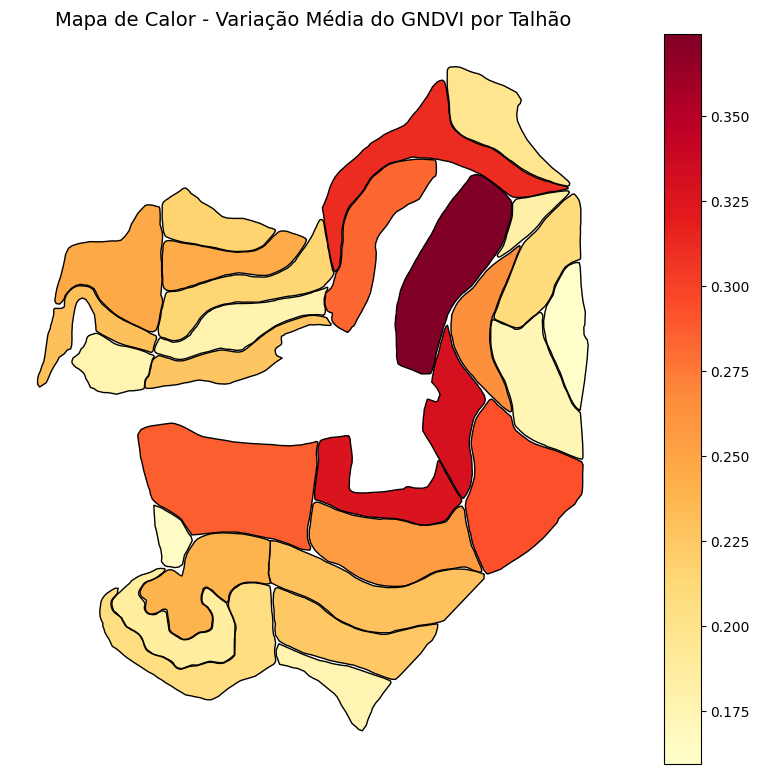

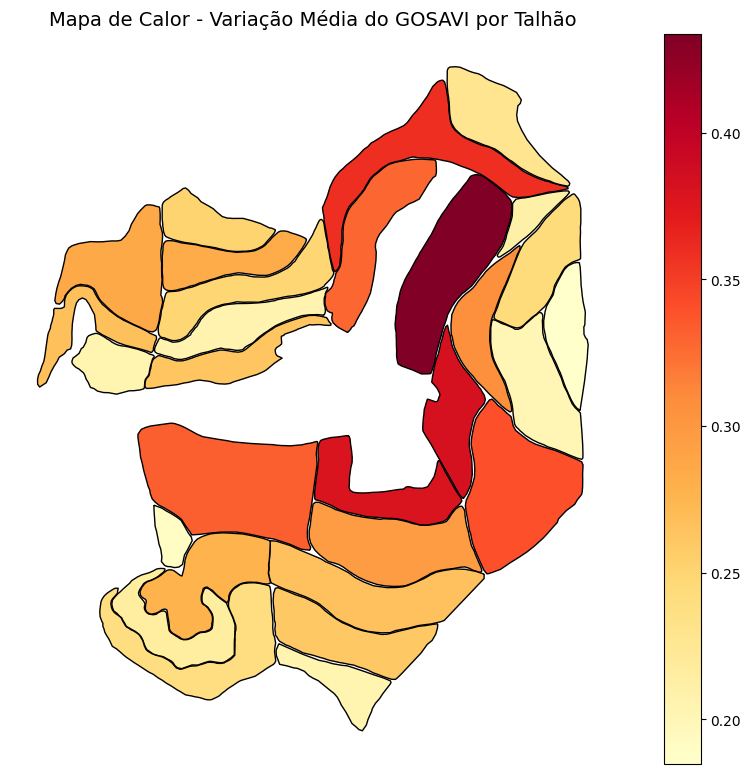

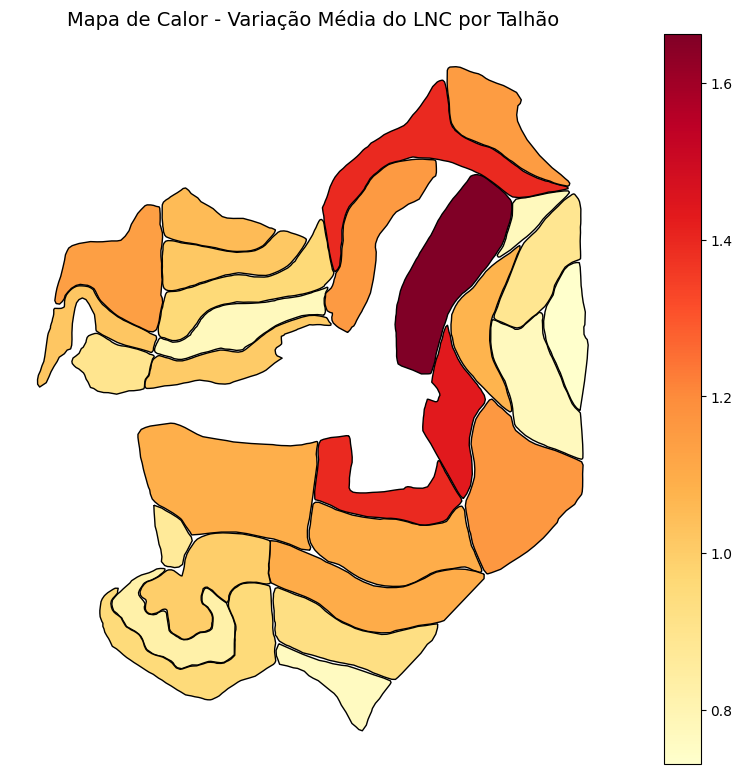

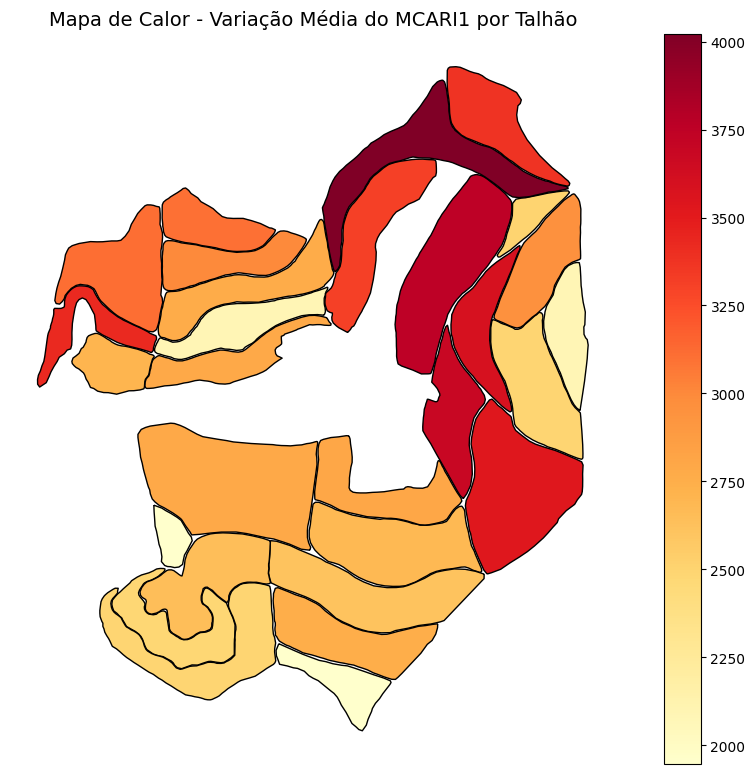

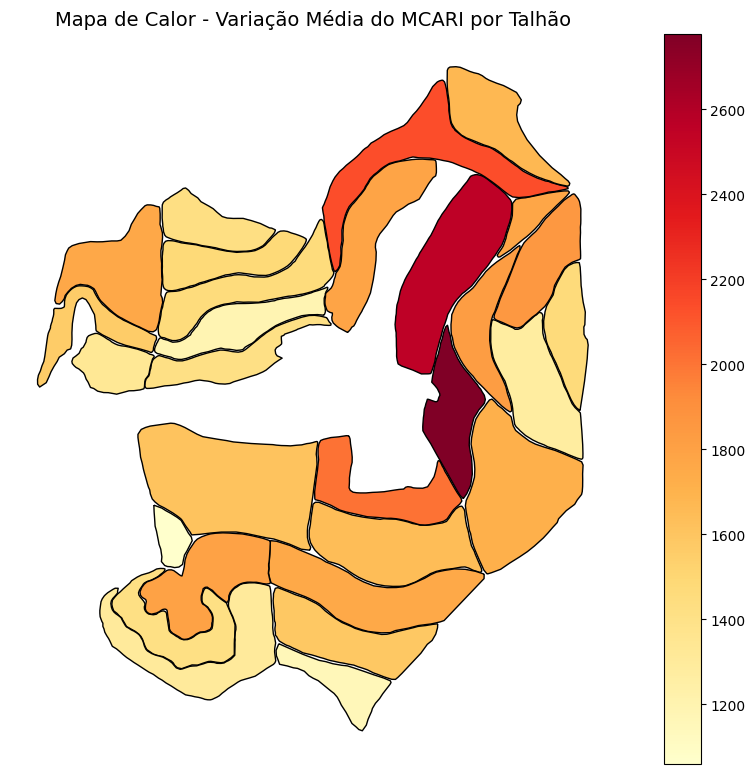

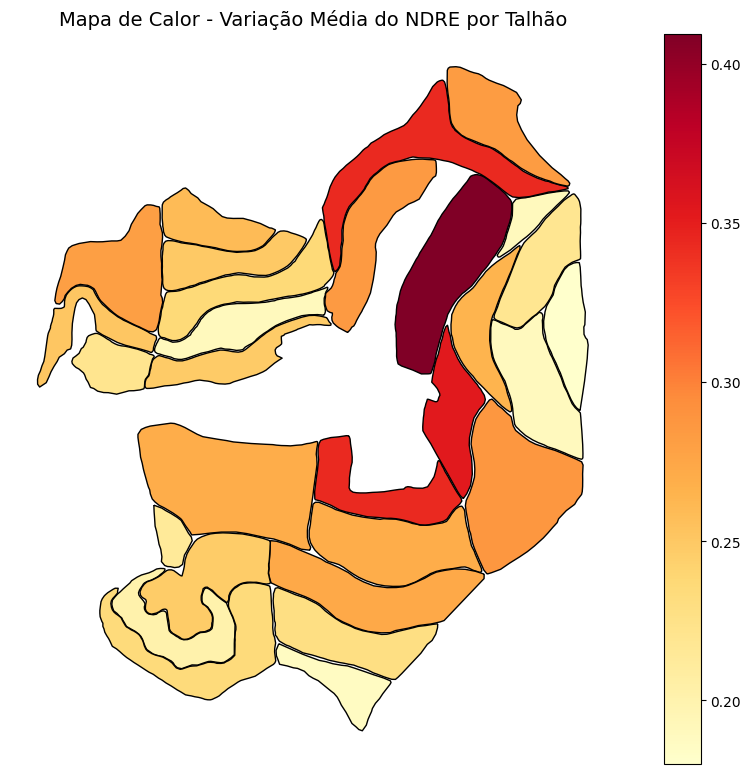

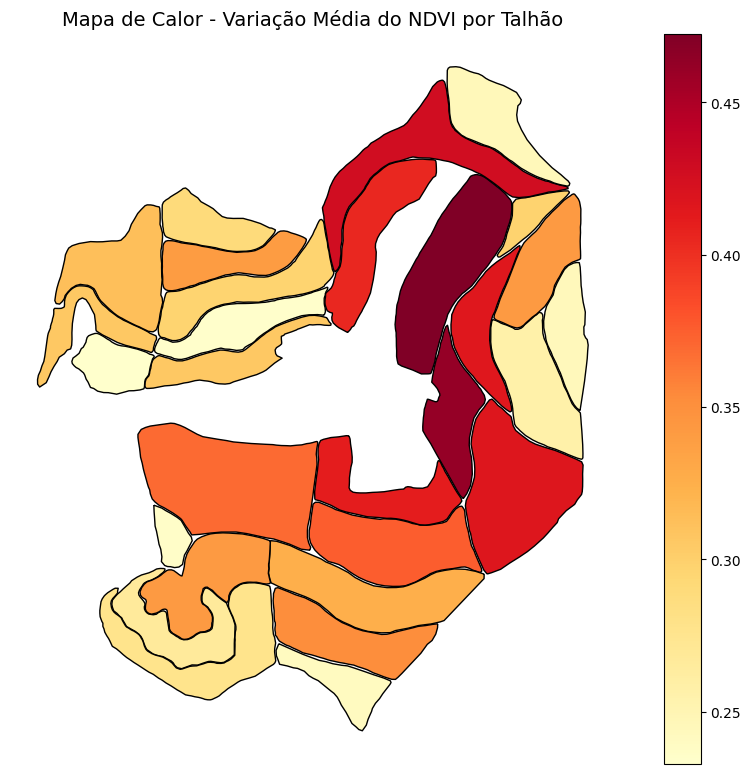

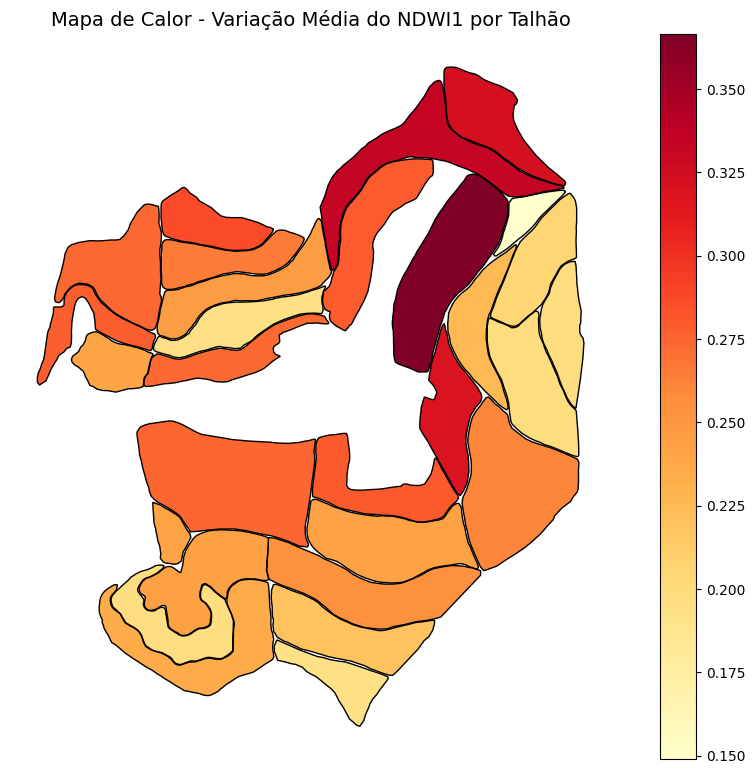

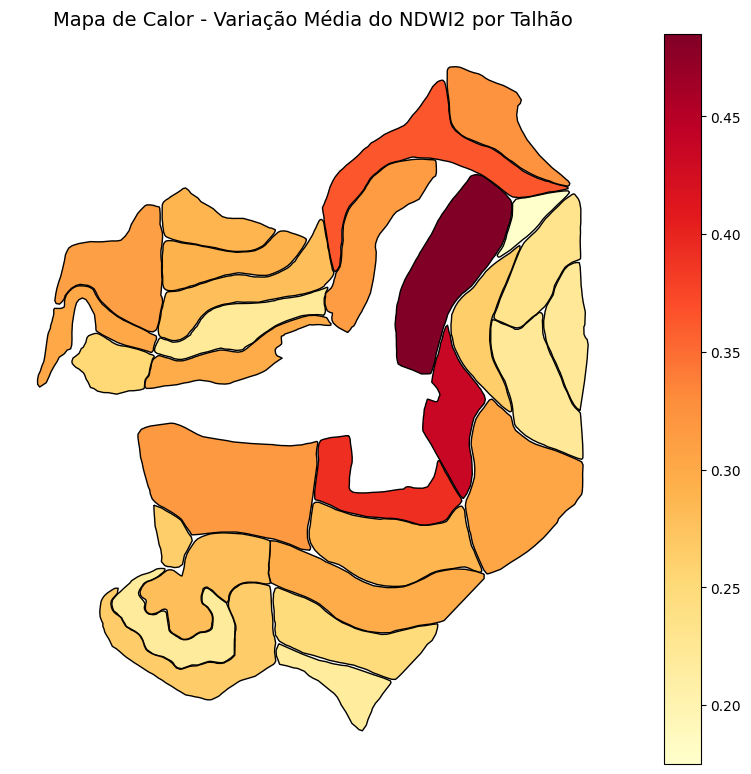

In [ ]:
# Calcular varia√ß√£o (max - min) por √≠ndice e talh√£o ao longo do tempo
df['amplitude'] = df['max'] - df['min']
df_var = df.groupby(['id_talhao', 'indice'])['amplitude'].mean().reset_index()

# Juntar com geometrias para plotar no mapa
gdf_mapa = gdf_talhoes.copy()
gdf_mapa = gdf_mapa.merge(df_var, left_on=col_id_talhao, right_on='id_talhao')

# Plotar mapa para cada √≠ndice
for indice in df['indice'].unique():
    gdf_plot = gdf_mapa[gdf_mapa['indice'] == indice]

    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    gdf_plot.plot(
        column='amplitude',
        ax=ax,
        legend=True,
        cmap='YlOrRd',
        edgecolor='black'
    )
    ax.set_title(f"Mapa de Calor - Varia√ß√£o M√©dia do {indice} por Talh√£o", fontsize=14)
    ax.axis('off')
    plt.tight_layout()
    plt.show()


In [ ]:
# Gr√°fico de linha para cada talh√£o (removendo MCARI e MCARI1)
talhoes_unicos = sorted(df['id_talhao'].unique(), key=lambda x: int(x)) # Ordenar numericamente

for talhao in talhoes_unicos:
    df_talhao = df[(df['id_talhao'] == talhao) & (~df['indice'].isin(['MCARI', 'MCARI1']))].sort_values('data')
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=df_talhao, x='data', y='mean', hue='indice', marker='o')
    plt.title(f'Evolu√ß√£o dos √çndices - Talh√£o {talhao}')
    plt.xlabel('Data')
    plt.ylabel('Valor M√©dio do √çndice')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend(title='√çndice')
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import os
import re
import glob
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict

pasta_imgs = '/content/drive/MyDrive/Dissertacao/indices/indices_recortados/oasis'  # ajuste se necess√°rio
arquivos_tif = glob.glob(os.path.join(pasta_imgs, '*.tif'))

print(f"Total de arquivos encontrados: {len(arquivos_tif)}")

padrao = re.compile(r'([A-Za-z0-9]+).*?(\d{4}-\d{2})')

for arq in arquivos_tif:
    nome_base = os.path.basename(arq)
    match = padrao.match(nome_base)
    if match:
        print(f"[‚úîÔ∏è OK] {nome_base} ‚Üí √≠ndice: {match.group(1)}")
    else:
        print(f"[‚ùå FALHOU] {nome_base} ‚Üí padr√£o n√£o reconhecido")

def gerar_mapa_variacao_por_indice(pasta_tifs):
    arquivos_tif = sorted(glob.glob(os.path.join(pasta_tifs, '*.tif')))
    indices_dict = defaultdict(list)

    # Agrupar arquivos por √≠ndice
    for arquivo in arquivos_tif:
        nome_base = os.path.basename(arquivo).replace('.tif', '')
        match = re.match(r"([A-Za-z0-9]+).*?(\d{4}-\d{2})", nome_base)
        if match:
            indice = match.group(1)
            indices_dict[indice].append((match.group(2), arquivo))

    print(f"\nüéØ √çndices encontrados: {list(indices_dict.keys())}\n")

    for indice, arquivos in tqdm(indices_dict.items(), desc="Gerando mapas de varia√ß√£o"):
        arquivos = sorted(arquivos)  # Ordena por data
        pilha = []

        for _, caminho in arquivos:
            with rasterio.open(caminho) as src:
                array = src.read(1).astype(np.float32)

                # Substitui valores inv√°lidos por NaN
                if src.nodata is not None:
                    array[array == src.nodata] = np.nan
                else:
                    array[array <= -9999] = np.nan  # valor comum de nodata

                pilha.append(array)

        if len(pilha) < 2:
            print(f"‚ö†Ô∏è N√£o h√° imagens suficientes para calcular varia√ß√£o do √≠ndice {indice}")
            continue

        print(f"üìä Empilhando {len(pilha)} imagens para o √≠ndice {indice}...")

        # Converter lista para array 3D: (tempo, altura, largura)
        pilha_array = np.stack(pilha, axis=0)

        # Calcular desvio padr√£o por pixel
        variacao = np.nanstd(pilha_array, axis=0)

        # Verifica se h√° alguma varia√ß√£o real
        if np.all(np.isnan(variacao)) or np.nanmax(variacao) == 0:
            print(f"‚ùå Varia√ß√£o nula ou inv√°lida para o √≠ndice {indice}")
            continue

        # Exibir mapa de calor
        plt.figure(figsize=(10, 6))
        plt.imshow(variacao, cmap='inferno')
        plt.colorbar(label='Desvio padr√£o por pixel')
        plt.title(f'üî• Varia√ß√£o Temporal por Pixel - √çndice {indice}')
        plt.axis('off')
        plt.tight_layout()
        plt.show()


Total de arquivos encontrados: 612
[‚úîÔ∏è OK] GNDVI_2018-05.tif ‚Üí √≠ndice: GNDVI
[‚úîÔ∏è OK] GNDVI_2018-06.tif ‚Üí √≠ndice: GNDVI
[‚úîÔ∏è OK] GNDVI_2018-07.tif ‚Üí √≠ndice: GNDVI
[‚úîÔ∏è OK] GNDVI_2018-08.tif ‚Üí √≠ndice: GNDVI
[‚úîÔ∏è OK] GNDVI_2018-09.tif ‚Üí √≠ndice: GNDVI
[‚úîÔ∏è OK] GNDVI_2018-12.tif ‚Üí √≠ndice: GNDVI
[‚úîÔ∏è OK] GNDVI_2019-01.tif ‚Üí √≠ndice: GNDVI
[‚úîÔ∏è OK] GNDVI_2019-02.tif ‚Üí √≠ndice: GNDVI
[‚úîÔ∏è OK] GNDVI_2019-03.tif ‚Üí √≠ndice: GNDVI
[‚úîÔ∏è OK] GNDVI_2019-04.tif ‚Üí √≠ndice: GNDVI
[‚úîÔ∏è OK] GNDVI_2019-05.tif ‚Üí √≠ndice: GNDVI
[‚úîÔ∏è OK] GNDVI_2019-06.tif ‚Üí √≠ndice: GNDVI
[‚úîÔ∏è OK] GNDVI_2019-07.tif ‚Üí √≠ndice: GNDVI
[‚úîÔ∏è OK] GNDVI_2019-08.tif ‚Üí √≠ndice: GNDVI
[‚úîÔ∏è OK] GNDVI_2019-09.tif ‚Üí √≠ndice: GNDVI
[‚úîÔ∏è OK] GNDVI_2019-10.tif ‚Üí √≠ndice: GNDVI
[‚úîÔ∏è OK] GNDVI_2019-11.tif ‚Üí √≠ndice: GNDVI
[‚úîÔ∏è OK] GNDVI_2020-04.tif ‚Üí √≠ndice: GNDVI
[‚úîÔ∏è OK] GNDVI_2020-05.tif ‚Üí √≠ndice: GNDVI
[‚úîÔ∏è OK] GNDVI_2020-06.tif ‚Üí 


üéØ √çndices encontrados: ['LNC', 'MCARI1', 'MCARI', 'NDRE', 'NDVI', 'NDWI1', 'NDWI2']



Gerando mapas de varia√ß√£o:   0%|          | 0/7 [00:00<?, ?it/s]

üìä Empilhando 65 imagens para o √≠ndice LNC...


<ipython-input-12-9573e492dd4f>:78: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


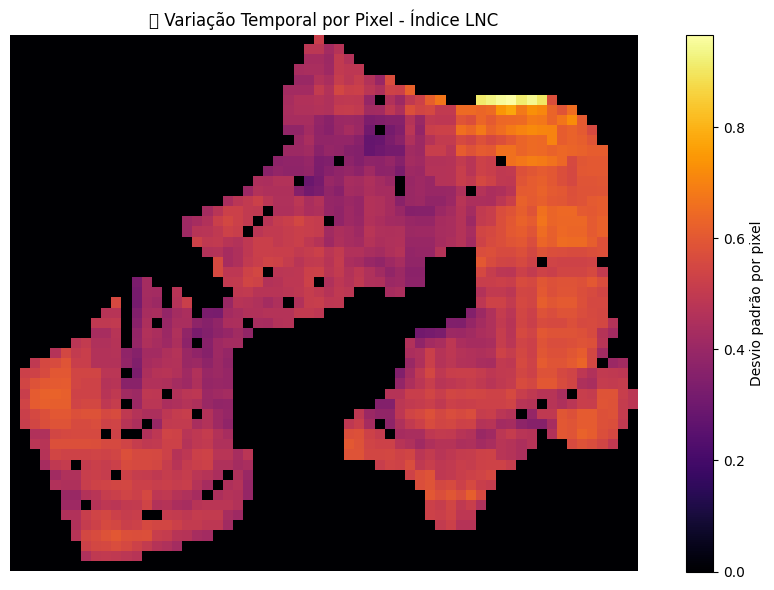

Gerando mapas de varia√ß√£o:  14%|‚ñà‚ñç        | 1/7 [00:01<00:10,  1.83s/it]

üìä Empilhando 65 imagens para o √≠ndice MCARI1...


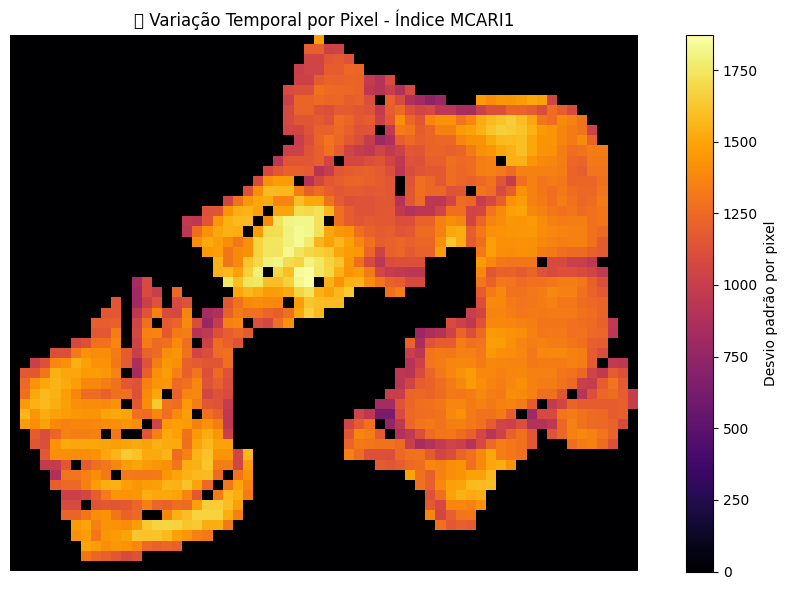

Gerando mapas de varia√ß√£o:  29%|‚ñà‚ñà‚ñä       | 2/7 [00:02<00:05,  1.19s/it]

üìä Empilhando 65 imagens para o √≠ndice MCARI...


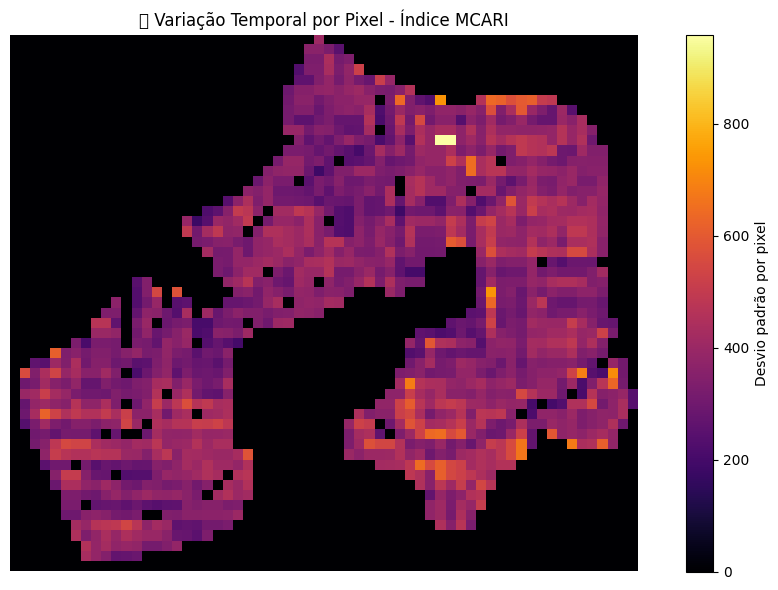

Gerando mapas de varia√ß√£o:  43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 3/7 [00:03<00:03,  1.01it/s]

üìä Empilhando 65 imagens para o √≠ndice NDRE...


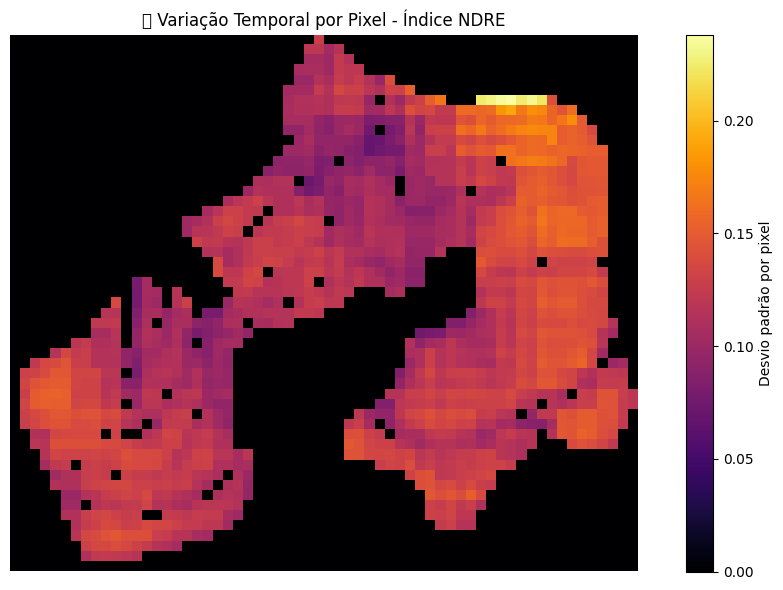

Gerando mapas de varia√ß√£o:  57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 4/7 [00:04<00:02,  1.12it/s]

üìä Empilhando 65 imagens para o √≠ndice NDVI...


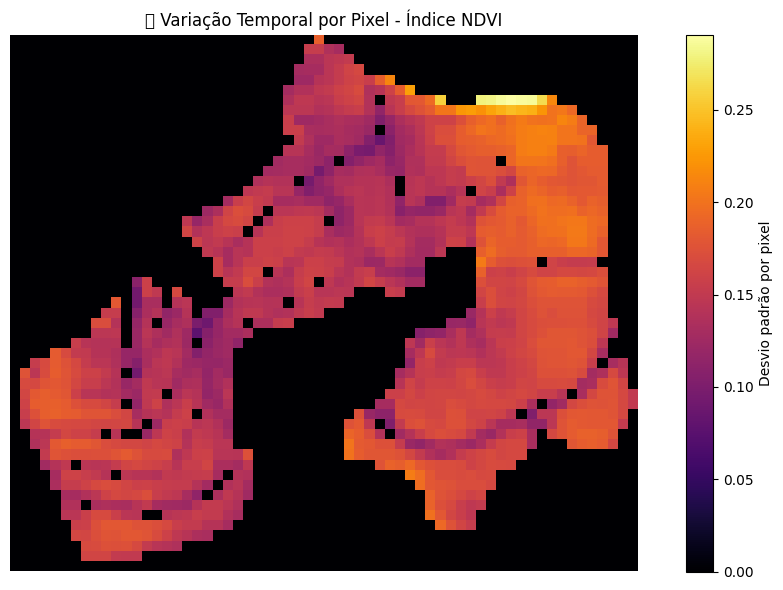

Gerando mapas de varia√ß√£o:  71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 5/7 [00:04<00:01,  1.19it/s]

üìä Empilhando 65 imagens para o √≠ndice NDWI1...


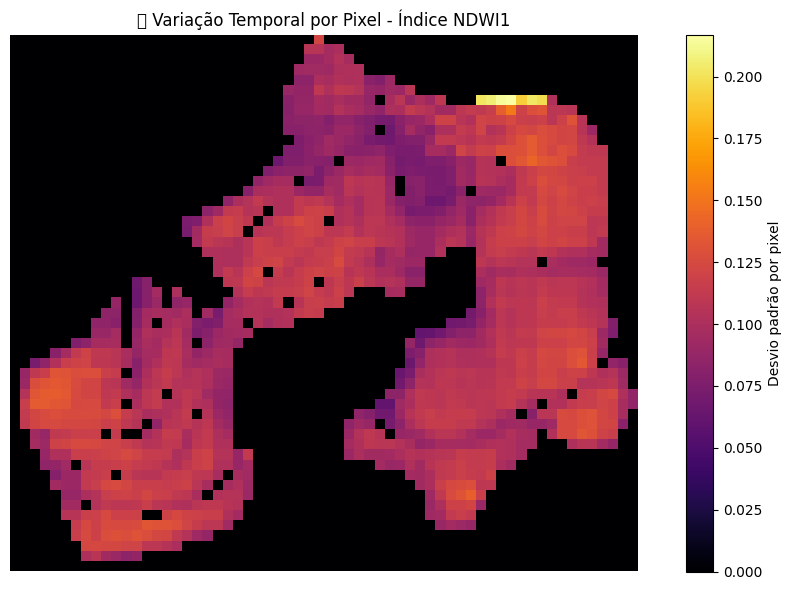

Gerando mapas de varia√ß√£o:  86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 6/7 [00:05<00:00,  1.23it/s]

üìä Empilhando 65 imagens para o √≠ndice NDWI2...


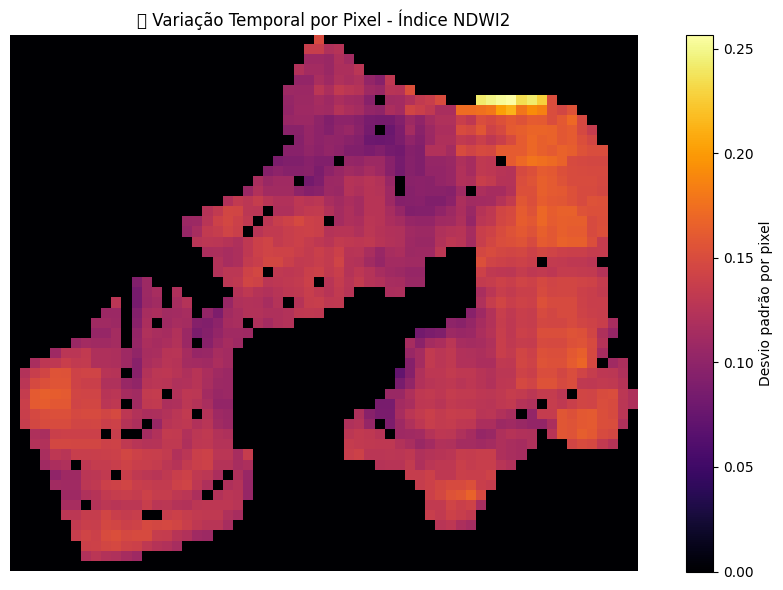

Gerando mapas de varia√ß√£o: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:06<00:00,  1.10it/s]


In [ ]:
gerar_mapa_variacao_por_indice('/content/drive/MyDrive/Dissertacao/indices/indices_recortados/ouro_fino')